![title](ccccc.png)

# MARKET BASKET ANALYSIS


### Group D.A.T.A:

**Filipe Pinho (M20190935)**;\
 **Francisco Neves (M20190089)**;\
 **Madalena Gomes (R2016699)**;\
 **Sofia Cunha (M20190795)**

# `IMPORT THE NEEDED LIBRARIES`

In [1]:
#! pip install mlxtend
#! pip install networkx
#! pip install plotly
#! pip install chart_studio

# Import packages
import csv
import pandas as pd
import numpy as np
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime as dt
from datetime import datetime 

#PLOTS 
import plotly.graph_objects as go
import pandas as pd
from plotly.offline import plot
from plotly.subplots import make_subplots


# `IMPORT THE DATASETS`

In [2]:
#Load and show dataset sample (Chain of Asian Restaurant sales in 2018)
# Table with the restaurant info 
normal = pd.DataFrame(pd.read_csv("AsianRestaurant_Cyprus_2018.txt",sep=";"))
# Table with the cyprus holidays
holidays = pd.DataFrame(pd.read_excel('Holidays_in_Cyprus.xlsx'))
# Table with the cyprus daily temperature during 2018
temperature = pd.DataFrame(pd.read_excel('Temp.xlsx'))

# `DATA PROCESSING`

### TABLE : NORMAL

In [3]:
normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84109 entries, 0 to 84108
Data columns (total 12 columns):
DocNumber             84109 non-null object
ProductDesignation    84109 non-null object
ProductFamily         84109 non-null object
Qty                   84109 non-null float64
TotalAmount           84109 non-null object
InvoiceDateHour       84109 non-null object
EmployeeID            84109 non-null int64
IsDelivery            84109 non-null int64
Pax                   84109 non-null int64
CustomerID            84109 non-null int64
CustomerCity          31248 non-null object
CustomerSince         29142 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 7.7+ MB


- As we can see from the information previously found, we have missing values in the variable CustumerID and CustomerSince.

Check if customers who have missing values in the CustomerCity variable are the ones who go to the restaurant (physical space).

In [4]:
normal[(normal['IsDelivery']==0) & (normal['CustomerCity'].isnull()==True)]

DocNumber           ProductDesignation ProductFamily  Qty  \
135    TK0110000012018               SWEETCORN SOUP         SOUPS  2.0   
136    TK0110000012018                  SPRING ROLL      STARTERS  2.0   
137    TK0110000012018               EGG FRIED RICE          RICE  1.0   
138    TK0110000012018           SWEET SOUR CHICKEN          MEAT  1.0   
139    TK0110000012018              LAMB ROGAN JOSH      MAIN IND  1.0   
...                ...                          ...           ...  ...   
84104  TK0110054642018           SWEET SOUR CHICKEN          MEAT  1.0   
84105  TK0110054642018                         COKE        DRINKS  1.0   
84106  TK0110054642018               EGG FRIED RICE          RICE  1.0   
84107  TK0110054642018  TOFFEE BANANA COMPLEMENTARY       DESSERT  1.0   
84108  TK0110054642018  TOFFEE BANANA COMPLEMENTARY       DESSERT  1.0   

      TotalAmount          InvoiceDateHour  EmployeeID  IsDelivery  Pax  \
135         12,00  2018-01-01 21:47:27.000           2           0    2   
136          5,80  2018-01-01 21:47:27.000           2           0    2   
137          6,90  2018-01-01 21:47:27.000           2           0    2   
138         12,60  2018-01-01 21:47:27.000           2           0    2   
139         14,60  2018-01-01 21:47:27.000           2           0    2   
...           ...                      ...         ...         ...  ...   
84104       12,60  2018-12-31 22:45:17.000           2           0    9   
84105        3,00  2018-12-31 22:45:17.000           2           0    9   
84106        6,90  2018-12-31 22:45:17.000           2           0    9   
84107        0,00  2018-12-31 22:45:17.000           2           0    9   
84108        0,00  2018-12-31 22:45:17.000           2           0    9   

       CustomerID CustomerCity CustomerSince  
135             0          NaN           NaN  
136             0          NaN           NaN  
137             0          NaN           NaN  
138             0          NaN           NaN  
139             0          NaN           NaN  
...           ...          ...           ...  
84104           0          NaN           NaN  
84105           0          NaN           NaN  
84106           0          NaN           NaN  
84107           0          NaN           NaN  
84108           0          NaN           NaN  

[52861 rows x 12 columns]

- We also found that all customers who consume in the restaurant have CustomerID = 0

Check the number of invoices that the restaurant issued in 2018

In [5]:
normal['DocNumber'].nunique()

11147

We also found that customers who have no value in the CustomerSince variable are customers who consume at the restaurant. In order to retain value of this variable in future analyzes, we opted to replace the Nan values with the value of the InvoiceDateHour (ie all customers who consume in the restaurant will be customers since 2018). Then we transformed the variable into a categorical one, YearsAsClient, the number of years that the person is our client. Later we will analyze this variable.

In [6]:
#Transform the TotalAmount values to float
normal['TotalAmount'] = normal['TotalAmount'].str.replace(',','.')
normal['TotalAmount'] = normal['TotalAmount'].astype(float)

In [7]:
#Replace the NAN values for the invoice date
normal.CustomerSince.fillna(normal.InvoiceDateHour, inplace=True)


In [8]:
lastday =pd.DataFrame({'lastday': ['2018-12-31']},index=np.arange(5000000))

#Converter para datetime
lastday['lastday'] = pd.to_datetime(lastday['lastday'])
lastday.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000000 entries, 0 to 4999999
Data columns (total 1 columns):
lastday    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 76.3 MB


In [9]:
#Convert to datetime
normal['CustomerSince'] = normal['CustomerSince'].values.astype('datetime64[D]')

In [10]:
# Calculate the number of days as client

normal['yac'] = (lastday['lastday'] - normal['CustomerSince'])

#convert timedelta to float
x = normal['yac']
days = x.astype('timedelta64[D]')

#days / np.timedelta64(1, 'D')
normal['YearsAsClient'] = days
normal.drop(['yac'], axis=1,inplace=True)

In [11]:
#Convert days to years - transform our variable into a categorical variable
normal.loc[normal['YearsAsClient'] < 365 , 'YearsAsClient'] = 0
normal.loc[(normal['YearsAsClient'] >= 365) & (normal['YearsAsClient'] < 730 ) , 'YearsAsClient'] = 1 
normal.loc[(normal['YearsAsClient'] >= 730) & (normal['YearsAsClient'] < 1095 ) , 'YearsAsClient'] = 2 
normal.loc[(normal['YearsAsClient'] >= 1096) & (normal['YearsAsClient'] < 1460 ) , 'YearsAsClient'] = 3
normal.loc[(normal['YearsAsClient'] >= 1460) & (normal['YearsAsClient'] < 1825 ) , 'YearsAsClient'] = 4
normal.loc[(normal['YearsAsClient'] >= 1825) & (normal['YearsAsClient'] < 2190 ) , 'YearsAsClient'] = 5
normal.loc[(normal['YearsAsClient'] >= 2190) & (normal['YearsAsClient'] < 2555 ) , 'YearsAsClient'] = 6
normal.loc[(normal['YearsAsClient'] >= 2555) & (normal['YearsAsClient'] < 2920 ) , 'YearsAsClient'] = 7
normal.loc[(normal['YearsAsClient'] >= 2920) & (normal['YearsAsClient'] < 3285 ) , 'YearsAsClient'] = 8
normal.loc[(normal['YearsAsClient'] >= 3285) & (normal['YearsAsClient'] < 3650 ) , 'YearsAsClient'] = 9
normal.loc[(normal['YearsAsClient'] >= 3650) & (normal['YearsAsClient'] < 4015 ) , 'YearsAsClient'] = 10
normal.loc[(normal['YearsAsClient'] >= 4015) & (normal['YearsAsClient'] < 4380 ) , 'YearsAsClient'] = 11
normal.loc[(normal['YearsAsClient'] >= 4380) & (normal['YearsAsClient'] < 4745 ) , 'YearsAsClient'] = 12
normal.loc[(normal['YearsAsClient'] >= 4745) & (normal['YearsAsClient'] < 5110 ) , 'YearsAsClient'] = 13


In [12]:
#Convert the InvoiceDateHour just to date
normal['InvoiceDateHour'] = normal['InvoiceDateHour'].astype('datetime64[ns]')
normal['InvoiceDateHour'] = normal['InvoiceDateHour'].dt.date
normal['InvoiceDateHour'] =  pd.to_datetime(normal['InvoiceDateHour'], format='%Y-%m-%d')
normal.drop(['CustomerSince'], axis=1,inplace=True)


Customers with CustumerCity! = Nan are the ones who ordered. We found some inconsistenciesin this variable, as for example Strovolos was in the form of STROBOLO and STROBOLOS. We therefore dealt with these problems.

- Customercity has cities and towns belonging to the district of Nicosia.

In [13]:
#Alterar variável CustomerCity
normal.loc[normal['CustomerCity'] == 'EGKOMI', 'CustomerCity'] = 'ENGOMI'
normal.loc[(normal['CustomerCity'] == 'LAKATAME') |( normal['CustomerCity'] == 'LAKSTAMEIA')  , 'CustomerCity'] = 'LACATÂMIA'
normal.loc[normal['CustomerCity'] == 'STROBOLO', 'CustomerCity'] = 'STROVOLOS'
normal.loc[normal['CustomerCity'] == 'STROBOLOS', 'CustomerCity'] = 'STROVOLOS'
normal.loc[normal['CustomerCity'] == 'LEYKOSIA', 'CustomerCity'] = 'NICOSIA'
normal.loc[normal['CustomerCity'] == 'LEYKOSIA', 'CustomerCity'] = 'NICOSIA'
normal.loc[normal['CustomerCity'] == 'AGLANTZIA', 'CustomerCity'] = 'AGLANDJIA'
normal.loc[normal['CustomerCity'] == 'SYN. ANTHOYPOLIS', 'CustomerCity'] = 'ANTHOUPOLIS'
normal.loc[normal['CustomerCity'] == 'PANO DEYTERA', 'CustomerCity'] = 'PANO DEFTERA'
normal.loc[normal['CustomerCity'] == 'LAKATAMEIA', 'CustomerCity'] = 'LACATÂMIA'

With the following graph, we can see the regions where we operate at the level of deliveries. For this, depending on the locations of our customers, we searched for lat and lon data from the center of each city or town. The ideal would be to have the exact coordinates of each client, in order to make a more complex analysis.

The size of the ball in each city or town depends on the amount of revenue, so as we can see Engomi is the city with the most TotalAmout.

In [14]:
data = pd.DataFrame({
         'lat': [35.1752 , 35.1459 , 35.0612, 35.1591 , 35.1000306 , 35.1085904 , 35.0944 , 35.1667 , 35.0817107 , 35.1338417 , 35.1139513 , 35.074164],
         'lon':[33.329,33.3902, 33.4047, 33.3177, 33.4215334, 33.3149413, 33.3767, 33.3666, 33.2672173, 33.3598366, 33.2896786,33.3233608],
         'name':['AGIOS DOMETIOS: ','AGLANDJIA: ' ,'DALI: ','ENGOMI: ', 'GERI: ', 'LACATÂMIA: ' , 'LATSIA: ', 'NICOSIA: ', 'PANO DEFTERA: ', 'STROVOLOS: ','ANTHOUPOLIS: ' , 'TSERI: '],
         'value':[29, 27, 25 ,40, 12, 29,23 , 33, 10, 35,12,18 ],
         'rec':[' 8737.70', '7488.06', '5144.56', '67153.63', '100.32', '31431.16' , '4318.42','44664.54','70.12','49581.24','115.38','415.74']})
    
site_lat = data.lat
site_lon = data.lon
site_value = data.value
data['concat']= data["name"] + data["rec"]
data['concat']
location=data.concat

#My access token
access_token= 'pk.eyJ1IjoicjIwMTY2OTkiLCJhIjoiY2s4MGx0cmVmMGhydDNldW41aXEyOWZ0ZiJ9.Nn09X_HGSxL6s-sI77Xfpw'   

dataa = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size= site_value,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=location,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=(site_value-5),
            color='rgb(242, 177, 172)',
            opacity=0.7
        ),
        hoverinfo='none'
    )]


layout = go.Layout(
    title='Clients Distribution',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=access_token,
        bearing=0,
        center=dict(
            lat=35.185566,
            lon=33.382275
        ),
        pitch=0,
        zoom=8,
        style='light'
    ),
)

fig = dict(data=dataa, layout=layout)

plot(fig, filename='Clients Distribution')


/Users/madalenabotelho/opt/anaconda3/lib/python3.7/site-packages/plotly/offline/offline.py:563: UserWarning:

Your filename `Clients Distribution` didn't end with .html. Adding .html to the end of your file.



'Clients Distribution.html'

### TABLE : HOLIDAYS

In [15]:
holidays.head()

Date DayOfTheWeek             HolidayName     TypeOfHoliday
0 2018-01-01       Monday          New Year's Day  National holiday
1 2018-01-06     Saturday                Epiphany  National holiday
2 2018-02-14    Wednesday         Valentine's Day        Observance
3 2018-02-19       Monday            Green Monday  National holiday
4 2018-03-25       Sunday  Greek Independence Day  National holiday

Merge between normal table and holidays table in one

In [16]:
merge=pd.merge(normal,holidays, left_on='InvoiceDateHour',right_on='Date', how='left')

### TABLE :  TEMPERATURE

In [17]:
temperature.head()

DayOfTheWeek       Date        AVG
0       Monday 2018-01-01  11.388889
1      Tuesday 2018-01-02  12.833333
2    Wednesday 2018-01-03  13.611111
3     Thursday 2018-01-04  12.277778
4       Friday 2018-01-05  11.888889

Merge between merged table above and the temperature table in one

In [18]:
merge_final = pd.merge(merge,temperature, left_on='InvoiceDateHour',right_on='Date', how='left')

### TABLE : FINAL

In [19]:
#Change column names and drop other columns
merge_final['DayOfTheWeek'] = merge_final['DayOfTheWeek_y']
merge_final.drop(['Date_x'], axis=1,inplace=True)
merge_final.drop(['Date_y'], axis=1,inplace=True)
merge_final.drop(['DayOfTheWeek_x'], axis=1,inplace=True)
merge_final.drop(['DayOfTheWeek_y'], axis=1,inplace=True)
merge_final

DocNumber           ProductDesignation ProductFamily  Qty  \
0      TKD0320000012018                     1/2 DUCK      STARTERS  1.0   
1      TKD0320000012018                  SPRING ROLL      STARTERS  8.0   
2      TKD0320000012018           SWEET SOUR CHICKEN          MEAT  2.0   
3      TKD0320000012018                LEMON CHICKEN          MEAT  1.0   
4      TKD0320000012018                     BEEF BBS      SIZZLING  1.0   
...                 ...                          ...           ...  ...   
84104   TK0110054642018           SWEET SOUR CHICKEN          MEAT  1.0   
84105   TK0110054642018                         COKE        DRINKS  1.0   
84106   TK0110054642018               EGG FRIED RICE          RICE  1.0   
84107   TK0110054642018  TOFFEE BANANA COMPLEMENTARY       DESSERT  1.0   
84108   TK0110054642018  TOFFEE BANANA COMPLEMENTARY       DESSERT  1.0   

       TotalAmount InvoiceDateHour  EmployeeID  IsDelivery  Pax  CustomerID  \
0             27.1      2018-01-01           2           1    1       53908   
1             17.6      2018-01-01           2           1    1       53908   
2             20.2      2018-01-01           2           1    1       53908   
3             10.1      2018-01-01           2           1    1       53908   
4             12.6      2018-01-01           2           1    1       53908   
...            ...             ...         ...         ...  ...         ...   
84104         12.6      2018-12-31           2           0    9           0   
84105          3.0      2018-12-31           2           0    9           0   
84106          6.9      2018-12-31           2           0    9           0   
84107          0.0      2018-12-31           2           0    9           0   
84108          0.0      2018-12-31           2           0    9           0   

      CustomerCity  YearsAsClient     HolidayName     TypeOfHoliday  \
0          NICOSIA            0.0  New Year's Day  National holiday   
1          NICOSIA            0.0  New Year's Day  National holiday   
2          NICOSIA            0.0  New Year's Day  National holiday   
3          NICOSIA            0.0  New Year's Day  National holiday   
4          NICOSIA            0.0  New Year's Day  National holiday   
...            ...            ...             ...               ...   
84104          NaN            0.0  New Year's Eve        Observance   
84105          NaN            0.0  New Year's Eve        Observance   
84106          NaN            0.0  New Year's Eve        Observance   
84107          NaN            0.0  New Year's Eve        Observance   
84108          NaN            0.0  New Year's Eve        Observance   

             AVG DayOfTheWeek  
0      11.388889       Monday  
1      11.388889       Monday  
2      11.388889       Monday  
3      11.388889       Monday  
4      11.388889       Monday  
...          ...          ...  
84104   9.500000       Monday  
84105   9.500000       Monday  
84106   9.500000       Monday  
84107   9.500000       Monday  
84108   9.500000       Monday  

[84109 rows x 16 columns]

In [20]:
# Round the values of column AVG
merge_final['AVG']= merge_final['AVG'].round(1) 

#### DUPLICATES 
We found that the duplicate values could be just another customer order for the same product, this happened about 8854 times. So we chose to join in a row, when DocNumber, ProductDesignation and Invoicedate were the same for several rows. And for that we had in mind to add the quantities ordered and the total_amount.

In [21]:
merge_final['Concat'] = merge_final['DocNumber'].map(str)  + merge_final['ProductDesignation'].map(str) + merge_final['InvoiceDateHour'].map(str) 

ids= merge_final['Concat']
duplicateRowsDF = merge_final[ids.isin(ids[ids.duplicated()])].sort_values(['Concat'])


In [22]:
#De seguida, tivemos de escolher apenas 1 linha para cada cliente. E escolher o melhor valor de todas as variáveis do dataset.

#DocNumber
DocNumber = duplicateRowsDF.groupby('Concat', as_index=False)['DocNumber'].min()

#ProductDesignation
ProductDesignation = duplicateRowsDF.groupby('Concat', as_index=False)['ProductDesignation'].min()

#ProductFamily
ProductFamily = duplicateRowsDF.groupby('Concat', as_index=False)['ProductFamily'].min()

#Qty
Qty = duplicateRowsDF.groupby('Concat', as_index=False)['Qty'].sum()

#TotalAmount
TotalAmount = duplicateRowsDF.groupby('Concat', as_index=False)['TotalAmount'].sum()

#InvoiceDateHour
InvoiceDateHour = duplicateRowsDF.groupby('Concat', as_index=False)['InvoiceDateHour'].min()

#EmployeeID
EmployeeID = duplicateRowsDF.groupby('Concat', as_index=False)['EmployeeID'].min()

#IsDelivery
IsDelivery = duplicateRowsDF.groupby('Concat', as_index=False)['IsDelivery'].min()

#Pax
Pax = duplicateRowsDF.groupby('Concat', as_index=False)['Pax'].max()

#CustomerID
CustomerID = duplicateRowsDF.groupby('Concat', as_index=False)['CustomerID'].min()

#CustomerCity
CustomerCity = duplicateRowsDF.groupby('Concat', as_index=False)['CustomerCity'].min()

#YearsAsClient
YearsAsClient = duplicateRowsDF.groupby('Concat', as_index=False)['YearsAsClient'].max()

#HolidayName
HolidayName = duplicateRowsDF.groupby('Concat', as_index=False)['HolidayName'].min()

#TypeOfHoliday
TypeOfHoliday = duplicateRowsDF.groupby('Concat', as_index=False)['TypeOfHoliday'].min()

#AVG
AVG = duplicateRowsDF.groupby('Concat', as_index=False)['AVG'].max()

#DayOfTheWeek
DayOfTheWeek = duplicateRowsDF.groupby('Concat', as_index=False)['DayOfTheWeek'].max()




In [23]:
duplicate_final = DocNumber
duplicate_final['ProductDesignation']= ProductDesignation['ProductDesignation']
duplicate_final['ProductFamily']= ProductFamily['ProductFamily']
duplicate_final['Qty']= Qty['Qty']
duplicate_final['TotalAmount']= TotalAmount['TotalAmount']
duplicate_final['InvoiceDateHour']= InvoiceDateHour['InvoiceDateHour']
duplicate_final['EmployeeID']= EmployeeID['EmployeeID']
duplicate_final['IsDelivery']= IsDelivery['IsDelivery']
duplicate_final['Pax']= Pax['Pax']
duplicate_final['CustomerID']= CustomerID['CustomerID']
duplicate_final['CustomerCity']= CustomerCity['CustomerCity']
duplicate_final['YearsAsClient']= YearsAsClient['YearsAsClient']
duplicate_final['HolidayName']= HolidayName['HolidayName']
duplicate_final['TypeOfHoliday']= TypeOfHoliday['TypeOfHoliday']
duplicate_final['AVG']= AVG['AVG']
duplicate_final['DayOfTheWeek']= DayOfTheWeek['DayOfTheWeek']

In [24]:
duplicate_final.fillna(value=pd.np.nan, inplace=True)

In [25]:
d_final = merge_final.drop_duplicates(subset=['Concat'], keep=False)

In [26]:
d_final=d_final.append(duplicate_final)
d_final=d_final.sort_values('Concat')
#hotel_final=hotel_final.set_index('Concat')


/Users/madalenabotelho/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




### FINAL TABLE 

In [27]:
d_final.drop(['Concat'], axis=1,inplace=True)
d_final.head()

AVG CustomerCity  CustomerID DayOfTheWeek        DocNumber  EmployeeID  \
143  11.4          NaN           0       Monday  TK0110000012018           2   
137  11.4          NaN           0       Monday  TK0110000012018           2   
140  11.4          NaN           0       Monday  TK0110000012018           2   
139  11.4          NaN           0       Monday  TK0110000012018           2   
142  11.4          NaN           0       Monday  TK0110000012018           2   

        HolidayName InvoiceDateHour  IsDelivery  Pax  \
143  New Year's Day      2018-01-01           0    2   
137  New Year's Day      2018-01-01           0    2   
140  New Year's Day      2018-01-01           0    2   
139  New Year's Day      2018-01-01           0    2   
142  New Year's Day      2018-01-01           0    2   

             ProductDesignation ProductFamily  Qty  TotalAmount  \
143  BOUTARI MOSCHOFILERO WHITE    WHITE WINE  1.0         26.9   
137              EGG FRIED RICE          RICE  1.0          6.9   
140                  JIRA PULAO      RICE IND  1.0          6.9   
139             LAMB ROGAN JOSH      MAIN IND  1.0         14.6   
142         MINERAL WATER 1.5LT        DRINKS  1.0          3.0   

        TypeOfHoliday  YearsAsClient  
143  National holiday            0.0  
137  National holiday            0.0  
140  National holiday            0.0  
139  National holiday            0.0  
142  National holiday            0.0

### TABLE WITH DATA BY INVOICE


In [28]:
df1 = d_final.groupby(['DocNumber']).agg({'CustomerID' : min ,'TotalAmount': sum ,'YearsAsClient' : min ,'CustomerCity' :min, 
                                       'InvoiceDateHour': min ,'DayOfTheWeek': min,'HolidayName': min ,  'AVG' :min,
                                    'EmployeeID':min, 'Pax': min, 'IsDelivery' : min })
df1.head()


CustomerID  TotalAmount  YearsAsClient CustomerCity  \
DocNumber                                                              
TK0110000012018           0         92.2            0.0          NaN   
TK0110000022018           0        209.6            0.0          NaN   
TK0110000032018           0         51.6            0.0          NaN   
TK0110000042018           0         75.5            0.0          NaN   
TK0110000052018           0         40.8            0.0          NaN   

                InvoiceDateHour DayOfTheWeek     HolidayName   AVG  \
DocNumber                                                            
TK0110000012018      2018-01-01       Monday  New Year's Day  11.4   
TK0110000022018      2018-01-01       Monday  New Year's Day  11.4   
TK0110000032018      2018-01-01       Monday  New Year's Day  11.4   
TK0110000042018      2018-01-01       Monday  New Year's Day  11.4   
TK0110000052018      2018-01-02      Tuesday             NaN  12.8   

                 EmployeeID  Pax  IsDelivery  
DocNumber                                     
TK0110000012018           2    2           0  
TK0110000022018           2    8           0  
TK0110000032018           2    2           0  
TK0110000042018           2    4           0  
TK0110000052018           2    2           0

# `EXPLORATORY ANALYSIS`
For this analysis we used d_final (final table with all the transactions) and the table df1 (by invoice).


Firstly, we will analyse the Employees, the Products (namely, those with higher demand and revenue), and the average expenditure per customer/day of the week.

##### 1) EMPLOYEE

In [29]:
employee = df1[['TotalAmount', 'EmployeeID']]
employee = employee.groupby('EmployeeID').sum().sort_values(by='EmployeeID', ascending=True)
employee['%'] = (employee['TotalAmount'] / sum(employee['TotalAmount']))*100


employee=employee.reset_index(level=0)
employee

EmployeeID  TotalAmount          %
0           2    574839.14  69.516453
1           4     19137.52   2.314339
2           5    108071.54  13.069309
3           6    106838.50  12.920195
4           7       189.60   0.022929
5          23      7660.90   0.926448
6          27     10173.72   1.230328

In [30]:
fig = go.Figure( 
    go.Bar(
            x=['ID=2','ID=4','ID=5','ID=6','ID=7','ID=23','ID=27'],
            y=employee['TotalAmount'],
            marker=dict(
             color='rgba(181, 74, 74, 0.86)',
             line=dict(color='rgba(185, 45, 45, 1)', width=2)
)))
fig.update_layout(plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)'),
                 title="Total Amount per Employee",yaxis_title="Total Amount")

fig.show()

- From the 11147 invoices registed in 2018, the employee with ID number 2 invoiced around 70% of the Total Amount, being the worker that brings more money to the restaurant. 

##### 1.1) Why does that happen? We will compare the dates, maybe he is the only one that worked in the restaurant the full year.

In [31]:
# SUBSTITUTE BY ALL THE ID's 
dd=df1[['InvoiceDateHour', 'EmployeeID']]
f= dd[dd['EmployeeID'] == 2]

`ID = 2 , BEGINNING = 01/01 , END = 31/12` 

`ID = 5 , BEGINNING = 11/03 , END = 30/12` 

`ID = 6 , BEGINNING = 03/01 , END = 29/12`

`ID = 4 , BEGINNING = 05/01 , END = 29/12`

`ID = 27, BEGINNING = 07/01 , END = 18/11`

`ID = 23, BEGINNING = 04/01 , END = 14/08`

`ID = 7 , BEGINNING = 24/08 , END = 24/08` 

- Employee number 7 only worked in the restaurant for 1 day;
- At the end of 2018, the restaurant only has 4 workers

###### 1.2)  Calcular o número de dias de trabalho por employee 

In [32]:
f= dd[dd['EmployeeID'] == 7]
f['InvoiceDateHour'].value_counts()



2018-08-24    1
Name: InvoiceDateHour, dtype: int64

`ID=2: worked 291 days` , `ID=5: worked 197 days` , `ID=6: worked 198 days` , 
`ID=4: worked 81 days` , `ID=27: worked 102 days` , `ID=23: worked 49 days ` ,`ID=7: worked 1 day`

- The employee number 6 worked more days than employee number 5, but number 5 has more value to the restaurant, relatively to the amount of revenue.

##### 2) PRODUCTS

In [33]:
productsales = pd.DataFrame(data=d_final[['ProductDesignation', 'TotalAmount']].groupby('ProductDesignation').sum().reset_index(level=0))
productcounts = pd.DataFrame(data=d_final['ProductDesignation'].value_counts().reset_index().rename(columns={'index':'ProductDesignation', 'ProductDesignation':'Counts'}))
products = pd.merge(productsales, productcounts)
products['Unit Price'] = products['TotalAmount']/products['Counts']

There are products that are demanded and ordered that do not have a cost. In our future analysis, we will analyse the Top 10 products with Unit Price = 0 and the Top 10 products that have a low total amount (excluding the products which have a unit price equal to zero).

##### 2.1) Calculate the Top 10

(1) Most Demanded  
(2) Least Demanded  
(3) More Revenue  
(4) Least Revenue

In [34]:
#(1) Most Demanded
top1 = products.sort_values(['Counts'],ascending=False).head(10)
top1

ProductDesignation  TotalAmount  Counts  Unit Price
151          MINERAL WATER 1.5LT     23168.70    5702    4.063259
98                EGG FRIED RICE     33549.85    4462    7.519016
216                  SPRING ROLL     35443.50    3968    8.932334
86               DELIVERY CHARGE      5025.80    3887    1.292977
220           SWEET SOUR CHICKEN     44652.90    3573   12.497313
18                      1/4 DUCK     43616.65    2416   18.053249
37                      BEEF BBS     35347.00    2248   15.723754
234  TOFFEE BANANA COMPLEMENTARY         0.00    1983    0.000000
164            NOODLES WITH MEAT     17334.65    1767    9.810215
237                       TSANTA       108.72    1749    0.062161

In [35]:
#(2) Least Demanded
top2 = products.sort_values(['Counts'],ascending=False).tail(10)
top2

ProductDesignation  TotalAmount  Counts  Unit Price
3              NO BABY CORN          0.0       1         0.0
74   CLASSIC ROLLS CUCUMBER          3.5       1         3.5
116     HADJIMICHALI LEFKOS         31.5       1        31.5
243          VEUVE CLICQUOT        115.0       1       115.0
132        KTIMA MALLIA RED         24.0       1        24.0
91        DOUREIOS ERYTHROS         30.0       1        30.0
10                  NO PORK          0.0       1         0.0
208              SORBET IND          7.6       1         7.6
75        CLASSIC ROLLS VEG          4.0       1         4.0
203       SELCTION FOR  TWO         20.4       1        20.4

In [36]:
#(3) Most Revenue
top3 = products.sort_values(['TotalAmount'],ascending=False).head(10)
top3

ProductDesignation  TotalAmount  Counts  Unit Price
45          BUFFET SUSHI    104360.00    1436   72.674095
220   SWEET SOUR CHICKEN     44652.90    3573   12.497313
18              1/4 DUCK     43616.65    2416   18.053249
216          SPRING ROLL     35443.50    3968    8.932334
37              BEEF BBS     35347.00    2248   15.723754
98        EGG FRIED RICE     33549.85    4462    7.519016
151  MINERAL WATER 1.5LT     23168.70    5702    4.063259
17              1/2 DUCK     22503.70     719   31.298609
105                 FOOD     20885.03     320   65.265719
19              1/6 DUCK     18071.00    1546   11.688875

In [37]:
#(4) Least Revenue (Excluding the products with Unit Price = 0)
top4 = products[products['TotalAmount']!=0].sort_values(['TotalAmount'],ascending=False).tail(10)
top4

ProductDesignation  TotalAmount  Counts  Unit Price
203       SELCTION FOR  TWO         20.4       1   20.400000
236                   TONIC         15.0       4    3.750000
184          PRAWN CRACKERS         14.2     820    0.017317
104           FILTER COFFEE         13.2       3    4.400000
161                 NESCAFE         13.2       3    4.400000
87                  DESSERT         10.0       2    5.000000
28         ASSORTED PICKLES          8.8       4    2.200000
208              SORBET IND          7.6       1    7.600000
75        CLASSIC ROLLS VEG          4.0       1    4.000000
74   CLASSIC ROLLS CUCUMBER          3.5       1    3.500000

In [38]:
#Plot (1) e (2) - Demand

l1 = top1['ProductDesignation']
l2 = top2['ProductDesignation']

# Define color sets of paintings
red =['rgb(250,128,114)','rgb(205,92,92)','rgb(194,24,7)','rgb(178,34,34)',
     'rgb(150,0,24)','rgb(124,10,2)','rgb(141,2,31)','rgb(128,0,0)','rgb(94,25,20)','rgb(66,13,9)']
green=['rgb(198, 243, 138)','rgb(190, 237, 127)','rgb(181, 229, 118)','rgb(168, 217, 104)',
       'rgb(158, 208, 92)','rgb(146, 197, 78)','rgb(135, 186, 66)','rgb(122, 174, 54)','rgb(112, 162, 45)','rgb(98, 147, 35)']
        
# Create subplots, using 'domain' type for pie charts
specs = [[{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=1, cols=2, specs=specs,subplot_titles=("Top 10 most most demanded products", "Top 10 least demanded products"))                     
    
# Define pie charts
fig.add_trace(go.Pie(labels=l1, values=top1['Counts'], name='Most Demanded', marker_colors=green), 1, 1)

fig.add_trace(go.Pie(labels=l2, values=top2['Counts'], name='Least Demanded',marker_colors=red), 1, 2)
    
# Tune layout and hover info
fig.update_traces(hoverinfo='label+value+name', textinfo='none')

fig.update(layout_title_text='DEMAND', layout_showlegend=True)

fig = go.Figure(fig)
fig.update_layout(font=dict(color='rgb(0, 0, 0)'))

fig.show()     

- As it can be observed, the most requested product is the Mineral Water 1.5L, with 5702 requests, followed by the Egg Fried Rice, with 4462 requests, and the Spring Roll, with 3968 requests.
- Regarding the least requested products, there are several that had only one request during the years. Some of those products are the Veuve Clicquot, the Kitma Mallia Red and the Doureios Erythros

In [39]:
l3=top3['ProductDesignation']
l=top4['ProductDesignation']

red =['rgb(250,128,114)','rgb(205,92,92)','rgb(194,24,7)','rgb(178,34,34)',
     'rgb(150,0,24)','rgb(124,10,2)','rgb(141,2,31)','rgb(128,0,0)','rgb(94,25,20)','rgb(66,13,9)']
green=['rgb(198, 243, 138)','rgb(190, 237, 127)','rgb(181, 229, 118)','rgb(168, 217, 104)',
       'rgb(158, 208, 92)','rgb(146, 197, 78)','rgb(135, 186, 66)','rgb(122, 174, 54)','rgb(112, 162, 45)','rgb(98, 147, 35)']
# Create subplots, using 'domain' type for pie charts
specs = [[{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=1, cols=2, specs=specs,subplot_titles=("Top 10  products with most revenue", "Top 10 products with least revenue"))


fig.add_trace(go.Pie(labels=l3, values=top3['TotalAmount'], name='Most Revenue',marker_colors=green), 1, 1)

fig.add_trace(go.Pie(labels=l, values=top4['TotalAmount'], name='Least Revenue',marker_colors=red), 1, 2)

# Tune layout and hover info
fig.update_traces(hoverinfo='label+value+name', textinfo='none')

fig.update(layout_title_text='REVENUE', layout_showlegend=True)

fig = go.Figure(fig)
fig.update_layout(font=dict(color='rgb(0, 0, 0)'))
fig.show()

- The list of the products that bring the highest revenue to the company is highlighted by the Buffet Sushi, with 104.360€ at the end of the year, followed by Sweet Sour Chicken, with 44.652,90€ and 1/4 Duck with 43.616,65€. This shows the major difference between the revenue of the product in first place, and the second place.  
- However, some products did not call the attention of the customers. The products that brang the least revenue to the company were the Classic Rolls Cucumber, with 3,5€, the Classic Rools Veg, with 4€, and the Sorbet Ind, with just 7,6€ in one year.

##### 2.2) Demand for the products with Unit Price = 0

In [40]:
#Products which have Unit Price = 0

zero=products[products['TotalAmount']==0.0].sort_values(['Counts'],ascending=False).head(10)


- The products which have a unit price equal to zero, are mostly requests from the customer, for example, not wanting sauce, or egg, or onion in their meal

In [41]:
labels=zero['ProductDesignation']
values=zero['Counts']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,marker_colors=green)])

fig.update(layout_title_text='Top 10 Product Designation with Unit Price = 0')
fig.update_layout(font=dict(color='rgb(0, 0, 0)'))

fig.show()

- In this graph, it is clear that the most requested product, which unit cost is zero, is the Toffee Banana Complementary, with 48% of the requests of this type of products. This represents a huge difference for the second most requested product of this type, which is the Order of No Meat, with 26,2%. In fact, this does not correspond really to a product, as we mentioned before, but it is important to highlight this fact because it appears in the invoice. The third most requested product of this type is the Coffee Complimentary, with only 6,12%

##### 2.3) Top 10 products with higher unit cost

In [42]:
#Top 10 unit price
pu=products.sort_values(['Unit Price'],ascending=False).head(10)


In [43]:
fig = go.Figure( 
    go.Bar(
            x=pu['ProductDesignation'],
            y=pu['Unit Price'],
            marker=dict(
             color='rgba(181, 74, 74, 0.86)',
             line=dict(color='rgba(185, 45, 45, 1)', width=3)
)))
fig.update_layout(plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)'),
                 title="Top 10 products with higher unit cost",yaxis_title="Unit Price €")

fig.show()

- This restaurant has products from all types of costs associated. Some more expensive, and some are cheaper. When we talk about the most expensive products in this restaurant, the Special Buffet appears on top of the list, with a unit cost of 142,64€, followed by Veuve Clicquot, with 115€, and the Moet Chandon Brut, which costs 99,27€.  
  
  
- There are three very important annotations regarding this graph: 

  (1) The first one is that the most expensive product, Special Buffet, is not on the Top 10         products that bring more revenue to the company;  
  
  (2) The second point, is that the second most expensive product in the menu, Veuve Clicquot,       was only requested once in the year of 2018;  
  
  (3) And finally, the product that brings the most revevue to the company, Buffet Sushi, has       the fourth highest cost, with 72,67€.

##### 3)  PRODUCT FAMILIES
We are going to check which is the most requested product family and the most invoiced (TotalAmount)

In [44]:
familysales = pd.DataFrame(data=d_final[['ProductFamily', 'TotalAmount']].groupby('ProductFamily').sum().reset_index(level=0))
familycounts = pd.DataFrame(data=d_final['ProductFamily'].value_counts().reset_index().rename(columns={'index':'ProductFamily', 'ProductFamily':'Counts'}))
family = pd.merge(familysales, familycounts)

family['Counts%']=(family['Counts']/sum(family['Counts'])*100)
family['TA%']=(family['TotalAmount']/sum(family['TotalAmount'])*100)

In [45]:
y_saving = family['Counts%']

y_net_worth = family['TotalAmount']


x = family['ProductFamily']

# Creating two subplots
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)


fig.append_trace(go.Bar(
    x=y_saving,
    y=x,
    marker=dict(
        color='rgba(181, 74, 74, 0.86)',#cor da bar verde mar
        line=dict(
            color='rgba(185, 45, 45, 1)',#trace da bar verde
            width=3),
    ),
    name='Percentage of demand (%)',
    orientation='h',
), 1, 1)

fig.append_trace(go.Scatter(
    x=y_net_worth, y=x,
    mode='lines+markers',
    line_color='rgb(151, 214, 64)',# cor da linha roxo
    name='Annual earnings by product',
), 1, 2)
fig.update_layout(
    title='DEMAND VS PROFIT',
    autosize=False,
    width=1000,
    height=800,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
      #  linecolor='rgb(166, 166, 166)',#cor do traço que divide os gráficos
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
        title = 'Percentage of demand (%)',
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=25000,
        title = 'Total Amount (€)',

    ),
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(255, 255, 255)',
    plot_bgcolor='rgb(255, 255, 255)',
    font=dict(color='rgb(0, 0, 0)')
)

annotations = []

y_s = np.round(y_saving, decimals=2)
y_nw = np.rint(y_net_worth)

# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x):
    # labeling the scatter DEMAND
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn - 16,
                            text='{:,}'.format(ydn) + '€',
                            font=dict(family='Arial', size=1,
                                      color='rgb(0,0,0)'),#cor da letra roxo
                            showarrow=False))
    # labeling the bar PROFIT
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd + 1.5,
                            text=str(yd) + '%',
                            font=dict(family='Arial', size=1,
                                      color='rgb(0,0,0)'),#cor da letra verde
                            showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=-0.2, y=-0.109,
                        font=dict(family='Arial', size=10, color='rgb(0,0,0)'),#cinzento
                        showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()



- The graph above shows the comparation between the percentage of demand, and the revenue, in euros, from each Product Family.  


- The main conclusions that can be made are:  

    (1) Starters are the product family that have the highest number of requests, and consequently, the highest revenue at the end of the year, with over 168 thousand euros;  

    (2) Meat is less ordered than Rice in approximately 3%. However, Meat represented more revenue than Rice at the end of the year, with 33519€ more;

    (3) The desserts did not bring much revenue at the end of the year, with just 411€.

In [46]:
family.corr()

TotalAmount    Counts   Counts%       TA%
TotalAmount     1.000000  0.786573  0.786573  1.000000
Counts          0.786573  1.000000  1.000000  0.786573
Counts%         0.786573  1.000000  1.000000  0.786573
TA%             1.000000  0.786573  0.786573  1.000000

- TotalAmount and the number of orders are highly positive correlated.

#### For the next analysis, we will divide our dataframe in two new ones, restaurant and delivery. One will be directed to the restaurant, and the other to the home deliveries.

RESTAURANT:


In [47]:
restaurante = d_final[d_final['IsDelivery']==0]
restaurante

AVG CustomerCity  CustomerID DayOfTheWeek        DocNumber  \
143    11.4          NaN           0       Monday  TK0110000012018   
137    11.4          NaN           0       Monday  TK0110000012018   
140    11.4          NaN           0       Monday  TK0110000012018   
139    11.4          NaN           0       Monday  TK0110000012018   
142    11.4          NaN           0       Monday  TK0110000012018   
...     ...          ...         ...          ...              ...   
83661   9.5          NaN           0       Monday  TK0120008202018   
3344    9.5          NaN           0       Monday  TK0120008202018   
3345    9.5          NaN           0       Monday  TK0120008202018   
83659   9.5          NaN           0       Monday  TK0120008202018   
83662   9.5          NaN           0       Monday  TK0120008202018   

       EmployeeID     HolidayName InvoiceDateHour  IsDelivery  Pax  \
143             2  New Year's Day      2018-01-01           0    2   
137             2  New Year's Day      2018-01-01           0    2   
140             2  New Year's Day      2018-01-01           0    2   
139             2  New Year's Day      2018-01-01           0    2   
142             2  New Year's Day      2018-01-01           0    2   
...           ...             ...             ...         ...  ...   
83661           5  New Year's Eve      2018-12-31           0    6   
3344            5  New Year's Eve      2018-12-31           0    6   
3345            5  New Year's Eve      2018-12-31           0    6   
83659           5  New Year's Eve      2018-12-31           0    6   
83662           5  New Year's Eve      2018-12-31           0    6   

               ProductDesignation ProductFamily  Qty  TotalAmount  \
143    BOUTARI MOSCHOFILERO WHITE    WHITE WINE  1.0         26.9   
137                EGG FRIED RICE          RICE  1.0          6.9   
140                    JIRA PULAO      RICE IND  1.0          6.9   
139               LAMB ROGAN JOSH      MAIN IND  1.0         14.6   
142           MINERAL WATER 1.5LT        DRINKS  1.0          3.0   
...                           ...           ...  ...          ...   
83661           MALAI MANGO CHICK      MAIN IND  1.0         12.8   
3344          MINERAL WATER 1.5LT        DRINKS  3.0          9.0   
3345                         NAAN    BREADS IND  4.0         14.0   
83659                STEAMED RICE          RICE  2.0         11.0   
83662          SWEET SOUR CHICKEN          MEAT  1.0         12.6   

          TypeOfHoliday  YearsAsClient  
143    National holiday            0.0  
137    National holiday            0.0  
140    National holiday            0.0  
139    National holiday            0.0  
142    National holiday            0.0  
...                 ...            ...  
83661        Observance            0.0  
3344         Observance            0.0  
3345         Observance            0.0  
83659        Observance            0.0  
83662        Observance            0.0  

[48888 rows x 16 columns]

DELIVERY:

In [48]:
casa = d_final[d_final['IsDelivery']==1]
casa

AVG CustomerCity  CustomerID DayOfTheWeek         DocNumber  \
992    11.9    STROVOLOS        1818       Friday  TKD0310000012018   
996    11.9    STROVOLOS        1818       Friday  TKD0310000012018   
991    11.9    STROVOLOS        1818       Friday  TKD0310000012018   
994    11.9    STROVOLOS        1818       Friday  TKD0310000012018   
995    11.9    STROVOLOS        1818       Friday  TKD0310000012018   
...     ...          ...         ...          ...               ...   
83995   9.5    STROVOLOS       33349       Monday  TKD0320044522018   
84000   9.5    LACATÂMIA       34071       Monday  TKD0320044532018   
84002   9.5    LACATÂMIA       34071       Monday  TKD0320044532018   
84001   9.5    LACATÂMIA       34071       Monday  TKD0320044532018   
83999   9.5    LACATÂMIA       34071       Monday  TKD0320044532018   

       EmployeeID     HolidayName InvoiceDateHour  IsDelivery  Pax  \
992             6             NaN      2018-01-05           1    1   
996             6             NaN      2018-01-05           1    1   
991             6             NaN      2018-01-05           1    1   
994             6             NaN      2018-01-05           1    1   
995             6             NaN      2018-01-05           1    1   
...           ...             ...             ...         ...  ...   
83995           2  New Year's Eve      2018-12-31           1    1   
84000           2  New Year's Eve      2018-12-31           1    1   
84002           2  New Year's Eve      2018-12-31           1    1   
84001           2  New Year's Eve      2018-12-31           1    1   
83999           2  New Year's Eve      2018-12-31           1    1   

             ProductDesignation ProductFamily  Qty  TotalAmount TypeOfHoliday  \
992    CHICKEN MIXED VEGETABLES          MEAT  1.0         10.1           NaN   
996             DELIVERY CHARGE        EXTRAS  1.0          1.0           NaN   
991              EGG FRIED RICE          RICE  1.0          5.5           NaN   
994                MIX VEG MAKI     JAP SUSHI  1.0          3.6           NaN   
995                 SALMON MAKI     JAP SUSHI  1.0          5.0           NaN   
...                         ...           ...  ...          ...           ...   
83995        SWEET SOUR CHICKEN          MEAT  1.0         10.1    Observance   
84000                ALOO PALAK       VEG IND  1.0          7.0    Observance   
84002           DELIVERY CHARGE        EXTRAS  1.0          1.7    Observance   
84001                      NAAN    BREADS IND  3.0          9.6    Observance   
83999                    SAMOSA     START IND  1.0          3.4    Observance   

       YearsAsClient  
992              2.0  
996              2.0  
991              2.0  
994              2.0  
995              2.0  
...              ...  
83995            0.0  
84000            0.0  
84002            0.0  
84001            0.0  
83999            0.0  

[30451 rows x 16 columns]

##### 4) INVOICES BY DAY OF THE WEEK, INCLUDING AND EXCLUDING HOLIDAYS:

(1) The restaurant makes more money  
(2) There are more orders  
(3) Correlation between variables given the new circumstances  


##### 4.1) Restaurant

In [49]:
#A contar com feriado
days = pd.DataFrame(data=restaurante[['DayOfTheWeek', 'TotalAmount']].groupby('DayOfTheWeek').sum().reset_index(level=0))
dayc =pd.DataFrame(data=restaurante[['DayOfTheWeek', 'Pax']].groupby('DayOfTheWeek').sum().reset_index(level=0))
family1 = pd.merge(days, dayc)
family1

DayOfTheWeek  TotalAmount    Pax
0       Friday    108444.58  45844
1       Monday     46937.47  16834
2     Saturday    137425.63  59326
3       Sunday     67610.11  30297
4     Thursday     53369.72  20805
5      Tuesday     47533.75  18836
6    Wednesday    146368.79  28473

In [50]:
#Sem feriado
dfnonhol = restaurante.loc[restaurante.HolidayName.isnull()]

daysf = pd.DataFrame(data=dfnonhol[['DayOfTheWeek', 'TotalAmount']].groupby('DayOfTheWeek').sum().reset_index(level=0))
daycf =pd.DataFrame(data=dfnonhol[['DayOfTheWeek', 'Pax']].groupby('DayOfTheWeek').sum().reset_index(level=0))
family2 = pd.merge(daysf, daycf)

In [51]:
days=family2['DayOfTheWeek']

fig = go.Figure(data=[
    go.Bar(name='Total Amount with holidays', x=days, y=family1['TotalAmount'],
          marker=dict( 
                color='rgba(181, 74, 74, 0.86)',
                line=dict(color='rgba(185, 45, 45, 1)', width=2))),
    go.Bar(name='Total Amount without holidays', x=days, y=family2['TotalAmount'], 
          marker=dict(
                color='rgba(58, 71, 80, 0.6)',
                line=dict(color='rgba(58, 71, 80, 1.0)', width=2)
    ))
])
# Change the bar mode
fig.update_layout(barmode='group',plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)'),
                  title='Invoice by day of the week',yaxis=dict(range=[0, 150000],title='Total Amount (€)'))

fig.show()

- The bar graph above shows the earnings of each day of the week, and the comparison between the total with holidays, and without the holidays. The day of the week that had the highest amount was Wednesday, with 146 thousand euros with holidays and 138 thousand euros without holidays. The day with the second highest amount is also important to mention, since it does not have a big difference from the first, which was Saturday. Saturday had 137 thousand euros with holidays, and 133 thousand thousand euros without the holidays.  

- The day of the week that presented the least amount of money at the end of the year was Monday, with 46,937 thousand euros. Monday was also the weekday that had the highest difference between the total with holidays, and the total without holidays. The total without holidays stands at 37,138 thousand euros, representing a difference of 9,799 thousand euros, which means that Monday was the day of the week that had more money spent, whenever it was a holiday.

##### 4.2) Delivery

In [52]:
#WITH HOLIDAYS
dayd = pd.DataFrame(data=casa[['DayOfTheWeek', 'TotalAmount']].groupby('DayOfTheWeek').sum().reset_index(level=0))
dayg =pd.DataFrame(data=casa[['DayOfTheWeek', 'Pax']].groupby('DayOfTheWeek').sum().reset_index(level=0))
family3 = pd.merge(dayd, dayg)
family3

DayOfTheWeek  TotalAmount   Pax
0       Friday     49176.62  6910
1       Monday     25892.54  3418
2     Saturday     45054.60  6281
3       Sunday     29650.76  4016
4     Thursday     23988.75  3486
5      Tuesday     18987.76  2709
6    Wednesday     26469.84  3631

In [53]:
#WITHOUT HOLIDAYS
dfnonhol = casa.loc[casa.HolidayName.isnull()]

daysc = pd.DataFrame(data=dfnonhol[['DayOfTheWeek', 'TotalAmount']].groupby('DayOfTheWeek').sum().reset_index(level=0))
daycg =pd.DataFrame(data=dfnonhol[['DayOfTheWeek', 'Pax']].groupby('DayOfTheWeek').sum().reset_index(level=0))
family4 = pd.merge(daysc, daycg)


In [54]:
days=family4['DayOfTheWeek']

fig = go.Figure(data=[
    go.Bar(name='Total Amount with holidays', x=days, y=family3['TotalAmount'],
          marker=dict( 
                color='rgb(203, 252, 134)',
                line=dict(color='rgb(151, 214, 64)', width=2))),
    go.Bar(name='Total Amount without holidays', x=days, y=family4['TotalAmount'], 
          marker=dict(
                color='rgba(58, 71, 80, 0.6)',
                line=dict(color='rgba(58, 71, 80, 1.0)', width=2)
    ))
])
# Change the bar mode
fig.update_layout(barmode='group',plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)'),
                  title='Invoice by day of the week',yaxis=dict(range=[0, 150000], title='Total Amount (€)'))

fig.show()

- Regarding the total amount of the deliveries by weekday, this does not follow the trend of the meals served at the restaurant. In fact, the day of the week with the highest revenue in deliveries was Friday, with 49,18 thousand euros. Since there were no holidays on a Friday, the total amount excluding holidays is the same. The day of the week that had the second highest amount of revenue was Saturday, with 45,05 thousand euros total and 44,08 thousand euros excluding holidays. 


- Regarding the weekdays that had the least revenue, Tuesday was the day that overall had the smallest amount, with 18,99 thousand euros. However, Monday was the weekday that had the smallest amount, when excluding the holidays, with the amount of 17,39 thousand euros.  


- In comparison with the total amount of the meals served in the restaurant, the biggest difference was Wednesday, which had an average amount of 26,47 thousand euros with holidays, and 23,09 thousand euros, excluding holidays.

##### (5) AVERAGE EXPENDITURE PER PERSON,INCLUDING AND EXCLUDING HOLIDAYS

##### (5.1) Restaurant

In [55]:
#DATA WITHOUT HOLIDAYS

weekdaypax = restaurante.loc[restaurante.HolidayName.isnull()][['DayOfTheWeek', 'Pax', 'TotalAmount']].groupby('DayOfTheWeek').agg({'Pax':'sum', 'TotalAmount':'mean'})
weekdaypax= weekdaypax.rename(columns={'TotalAmount':'AverageExpenditures'})
weekdaypax

Pax  AverageExpenditures
DayOfTheWeek                            
Friday        45844            10.270346
Monday        12457            14.214674
Saturday      57426            10.463127
Sunday        28164            11.118497
Thursday      20805            10.967883
Tuesday       17830            11.034868
Wednesday     27289            21.934155

In [56]:
#WITH HOLIDAYS

weekdapax = pd.DataFrame(data=restaurante[['DayOfTheWeek', 'Pax', 'TotalAmount']].groupby('DayOfTheWeek').agg({'Pax':'sum', 'TotalAmount':'mean'}))
weekdapax = weekdapax.rename(columns={'TotalAmount':'AverageExpenditures'})
weekdapax

Pax  AverageExpenditures
DayOfTheWeek                            
Friday        45844            10.270346
Monday        16834            13.903279
Saturday      59326            10.460960
Sunday        30297            11.171532
Thursday      20805            10.967883
Tuesday       18836            11.129419
Wednesday     28473            22.086735

- Regarding the Average Expenditures per person in the restaurant, the day of the week with the highest expenditures was Wednesday, with 22,08€ with holidays, and 21,93€ excluding holidays. This fact corresponds to the Total Amount per weekday, which, like we mentioned before, this was the best day in terms of revenue.  


- What is an interesting fact is that, Monday, which was the day with the least Total Amount, is in fact, the weekday with the second highest expenditure per person in the restaurant, with 13,90€ total, and 14,21€ excluding holidays.  


- The rest of the days of the week presented very similar average expenditures, both in total of the year and excluding holidays, with values around 10€ and 11€.  


- Another important point to mention is that the number of clients in the restaurant is higher, when there is a holiday on a Monday.

##### (5.2) Delivery



In [57]:
#data without holidays

weekdaypax = casa.loc[casa.HolidayName.isnull()][['DayOfTheWeek', 'Pax', 'TotalAmount']].groupby('DayOfTheWeek').agg({'Pax':'sum', 'TotalAmount':'mean'})
weekdaypax= weekdaypax.rename(columns={'TotalAmount':'AverageExpenditures'})
weekdaypax

Pax  AverageExpenditures
DayOfTheWeek                           
Friday        6910             7.116732
Monday        2403             7.238568
Saturday      6155             7.161478
Sunday        3718             7.369925
Thursday      3486             6.881454
Tuesday       2509             7.022639
Wednesday     3210             7.193751

In [58]:
#with holidays

weekdapax = pd.DataFrame(data=casa[['DayOfTheWeek', 'Pax', 'TotalAmount']].groupby('DayOfTheWeek').agg({'Pax':'sum', 'TotalAmount':'mean'}))
weekdapax = weekdapax.rename(columns={'TotalAmount':'AverageExpenditures'})
weekdapax

Pax  AverageExpenditures
DayOfTheWeek                           
Friday        6910             7.116732
Monday        3418             7.575348
Saturday      6281             7.173157
Sunday        4016             7.383157
Thursday      3486             6.881454
Tuesday       2709             7.009140
Wednesday     3631             7.289959

- Overall, there is not a day of the week that stands out on the positive, neither on the negative, as every weekday appears with similar average expenditures, in values around 6€ and 7€. What is very important to mention, is that the average expenditures per order is very low.  
- This information leads to the conclusion that there is not a big increase in the amount spent by the clients when the number of orders also increase

##### 6) IN WHICH HOLIDAY:

(1) The restaurant makes more money  
(2) Is more crowded                                                                                                
(3) Correlation between variables given the new circumstances  

##### 6.1) Restaurant

In [59]:
#Dados das holidays (não sei se preferem average amount ou total amount)
holidaypax = restaurante.loc[restaurante.HolidayName.notnull()][['InvoiceDateHour', 'HolidayName', 'Pax', 'TotalAmount']].groupby('HolidayName').agg({'Pax':'sum', 'TotalAmount':'sum'})
holidaypax.reset_index(inplace=True)


In [60]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=holidaypax['HolidayName'],
        y=holidaypax['Pax'],
        marker=dict( 
                color='rgba(181, 74, 74, 0.86)',
                line=dict(color='rgba(185, 45, 45, 1)', width=1))
    ))

fig.add_trace(
    go.Bar(
        x=holidaypax['HolidayName'],
        y=holidaypax['TotalAmount'],
        marker=dict(
                color='rgba(58, 71, 80, 0.6)',
                line=dict(color='rgba(58, 71, 80, 1.0)', width=1)
    ),
    
))

fig.update_layout(plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)'),yaxis=dict(range=[0, 5000], title='Total Amount (€)'),
                  title="Total amount at restaurant per holiday")
fig.show()

- Regarding the holidays, and the revenue of invoices inside de restaurant, the holiday in which the restaurant made more money was Valentine's Day, with 5049€, followed by Christmas Eve, with 3742€ and Epiphany, with 3570€.  


- On the other hand, the holidays, in which the restaurant made less money were Mother's Day, with 286€, New Year's Day, with 428,9€, and Labour Day, with 480,25€.  


- As it is noticeable, the holiday that had more people inside the restaurant was Christmas Eve, with 2332 people, followed by Epiphany, with 1900 people.  The holidays that had less people inside the restaurant were Orthodox Pentecost Monday, with 115 people, and Mother's Day, with 122 people.  


- The Valentine's Day, which was the holiday with highest earnings, was very far from being the most crowded day at the restaurant, meaning that the expenditures were very high in that day.  


- On the other hand, Christmas Eve and Epiphany confirm the same trend as the revenue, by having two of the highest numbers, of all the holidays.

##### 6.2) Delivery

In [61]:
#Dados das holidays (não sei se preferem average amount ou total amount)
holidaypax = casa.loc[casa.HolidayName.notnull()][['InvoiceDateHour', 'HolidayName', 'Pax', 'TotalAmount']].groupby('HolidayName').agg({'Pax':'sum', 'TotalAmount':'sum'})
holidaypax.reset_index(inplace=True)

In [62]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=holidaypax['HolidayName'],
        y=holidaypax['Pax'],
        marker=dict( 
                color='rgb(203, 252, 134)',
                line=dict(color='rgb(151, 214, 64)', width=1))
    ))

fig.add_trace(
    go.Bar(
        x=holidaypax['HolidayName'],
        y=holidaypax['TotalAmount'],
        marker=dict(
                color='rgba(58, 71, 80, 0.6)',
                line=dict(color='rgba(58, 71, 80, 1.0)', width=1)
    ),
    
))

fig.update_layout(plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)'), yaxis=dict(range=[0, 5000], title='Total Amount (€)'),
                                  title="Total amount in deliveries per holiday")


fig.show()

- In an overall view, the revenue of the deliveries followed an identical trend of the earnings in the restaurant, with Valentine's Day, with 2856€, and Christmas Eve, with 1972€, being two of the holidays with the highest earnings.  


- However, there were two major differences between the earnings in the restaurant, and in the deliveries, which are the New Year's Eve and the Epiphany. In the restaurant, New Year's Eve was a day that did not bring much revenue to the company. However, the company made 3181€ in deliveries in this day, representing the highest amount of all the holidays in 2018. Regarding Epiphany, which presented great numbers in the restaurant, had an average revenue in deliveries, with 975,70€.


- Regarding the number of orders during the holidays, the three best holidays were the same that were in terms of revenue, which were Valentine's Day, with 342 orders, New Year's Eve, with 334 orders, and Christmas Eve, with 257 orders. In this case, Valentine's Day has a higher number of orders than the New Year's Eve, despite having less revenue.  


- In comparison with the numbers from the pax in the restaurant, we can also see that the Epiphany holiday was not very productive for the holidays, unlike Christmas Eve.

##### 7) AMOUNT OF REVENUE FROM DELIVERIES VS RESTAURANT

In [63]:
df = restaurante.groupby('HolidayName', as_index=False)['DocNumber'].count()
df1 = casa.groupby('HolidayName', as_index=False)['DocNumber'].count()

In [64]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=df['HolidayName'],
    x=df['DocNumber'],
    name='nº de invoices no restaurante',
    orientation='h',
    marker=dict(
        color='rgba(58, 71, 80, 0.6)',
            line=dict(color='rgba(58, 71, 80, 1.0)', width=2)
    )
))
fig.add_trace(go.Bar(
    y=df1['HolidayName'],
    x=df1['DocNumber'],
    name='nº de invoices nas entregas',
    orientation='h',
    marker=dict(
        color='rgb(203, 252, 134)',
        line=dict(color='rgb(151, 214, 64)', width=2)
    )
))

fig.update_layout(barmode='stack',plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)' ),
                                  title="Number of invoices by holiday",xaxis_title="Number of invoices")
fig['layout']['xaxis'].update(range=[0, 550], autorange=False)
fig.show()

- The comparison between the number of invoices in the restaurant and form deliveries in each holiday contains very important information, in order to understand if the values are similar for each day.  


- The most interesting days to mention are Valentine's Day, New Year's Eve and Epiphany, because those were the days with the highest number of invoices overall, but with great differences between the origin of those invoices (resraurant or delivery).  


- Beginning with Valentine's Day, it is very clear that the majority of the invoices came from deiveries, 342, when there were 179 invoices from the restaurant. Let's not forget that this was the holiday that had the highest revenue from invoices in the restaurant, and the second highest in deliveries.  


- As for New Year's Eve, this follows the same trend as Valentine's Day, with the majority of people ordering the meals to their homes, 334, and 128 customers had their meals at the restaurant.  


- Finally, during Epiphany, the opposite occured, with a strong percentage of people eating at the restaurant in comparison to the number of deliveries. In absolute numbers, 344 customers filled the dining room of the restaurant, as 126 customers had their meals home.

##### 8) CORRELATION BETWEEN INVOICE AND TEMPERATURE 
Invoice correlated with the temperature?

This analysis is important to understand if the will of the customers in eating at home or in the restaurant is influenced by the weather. For example, we aim to see if with lower temperatures, people tend to order food instead of going to the restaurant. Or if in a hot day, there are more customers in the restaurant.

##### 8.1) Restaurant

In [65]:
#Pax por temperatura (temperatura arredondada às unidades)

restaurante['AVG'] = restaurante['AVG'].round(0).astype(int)
temps = pd.DataFrame(data=restaurante[['AVG', 'Pax']].groupby('AVG').sum().reset_index(level=0))
tempc =pd.DataFrame(data=restaurante[['AVG', 'TotalAmount']].groupby('AVG').sum().reset_index(level=0))
fam = pd.merge(temps, tempc).sort_values(by='Pax', ascending=False)
fam

/Users/madalenabotelho/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



AVG    Pax  TotalAmount
6    15  20584     48497.55
3    12  19332     57609.90
20   29  16070     47433.82
5    14  14797     36803.05
18   27  13756     35655.83
4    13  12858     32563.35
17   26  12431     36305.70
13   22  11057     28670.10
7    16  10353     28843.00
9    18   9125     29635.45
19   28   7992     23075.86
16   25   7272     20117.93
21   30   7147     20971.42
14   23   6684     23177.30
1    10   6625     14996.05
8    17   6555     22539.60
0     9   5687     11899.45
11   20   5478     13264.60
15   24   4887     16693.70
22   31   4402     13992.95
12   21   4316     12950.40
2    11   4059      9555.95
10   19   4019     10237.70
23   32   3705      8502.61
24   33   1224      3696.78

- Overall, there is not a clear association between the temperature and the number of customers in the restaurant. The days in which the restaurant was more crowded had temperatures of 15ºC (20584 customers) , 12ºC (19332 customers) and 29ºC (16070 customers). On the other hand, the days in which the restaurant had less people had temperatures of 33ºC (1224ºC), 32ºC (3705 customers) and 19ºC (4019 customers). So, the two days with the highest temperatures had less people in the restaurant, but when there were 30º, the restaurant had 7147 customers, which was a good day.  


Now, we will compute the correlation matrix, to see if statistically, this confirms.

In [66]:
fam.corr()

AVG       Pax  TotalAmount
AVG          1.000000 -0.270083    -0.196551
Pax         -0.270083  1.000000     0.973524
TotalAmount -0.196551  0.973524     1.000000

As we can observe, the temperature and the number of people in the restaurant have a very weak negative correlation, which confirms what we analysed above.

##### 8.2) Delivery


In [67]:
casa['AVG'] = casa['AVG'].round(0).astype(int)
temps = pd.DataFrame(data=casa[['AVG', 'Pax']].groupby('AVG').sum().reset_index(level=0))
tempc =pd.DataFrame(data=casa[['AVG', 'TotalAmount']].groupby('AVG').sum().reset_index(level=0))
fam1= pd.merge(temps, tempc).sort_values(by='Pax', ascending=False)
fam1

/Users/madalenabotelho/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



AVG   Pax  TotalAmount
3    12  3153     24074.86
6    15  2720     19505.04
5    14  1999     14357.32
20   29  1997     13940.40
18   27  1827     12946.53
17   26  1465     10362.18
4    13  1454     10651.06
13   22  1422     10252.26
7    16  1360      9657.42
16   25  1296      9717.26
9    18  1162      7995.72
1    10  1112      9119.02
8    17   988      6462.42
14   23   964      6986.48
19   28   923      6044.42
21   30   916      6821.74
15   24   873      6313.60
12   21   856      6076.08
11   20   762      5509.22
22   31   691      4840.44
0     9   674      5065.48
10   19   648      4603.58
23   32   474      3055.86
2    11   471      3301.86
24   33   244      1560.62

- Once again, there is not a clear association between the temperature and the number of invoices. In this case of the deliveries, the days with the highest number of invoices had temperatures of 12ºC (3153 invoices), 15ºC (2720 invoices) and 14ºC (1999 invoices). As for the days with least invoices, the temperatures were 33ºC (244 invoices), 11ºC (471 invoices) and 32ºC (474 invoices).

In [68]:
fam1.corr()

AVG       Pax  TotalAmount
AVG          1.000000 -0.298324    -0.327588
Pax         -0.298324  1.000000     0.996731
TotalAmount -0.327588  0.996731     1.000000

- Just like the data from the restaurant, the correlation matrix between the temperature and the total number of invoices for deliveries presented a small negative correlation.

In [69]:
days=fam1['AVG']

fig = go.Figure(data=[
    go.Bar(name='Total Amount gain in the restaurant by temperature', x=days, y=fam['TotalAmount'],
          marker=dict( 
                color='rgba(181, 74, 74, 0.86)',
                line=dict(color='rgba(185, 45, 45, 1)', width=1))),
    go.Bar(name='Total Amount gain in delivery by temperature', x=days, y=fam1['TotalAmount'], 
          marker=dict(
                color='rgba(58, 71, 80, 0.6)',
                line=dict(color='rgba(58, 71, 80, 1.0)', width=1)
    ))
])
# Change the bar mode
fig.update_layout(barmode='group',plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)'),xaxis_title='Average temperature',
                  yaxis=dict(range=[0, 60000],title='Total amount (€)'), title='Total amount gain by temperature')

fig.show()

- The graph above shows the total amount earned by the company by temperature. In every case, is it clear that the amount from the restaurant is always higher than the amount from the deliveries. However, just like the total number of clients, we cannot establish an association between the temperature and the total amount.

#### As said before, we can only compute this next 3 calculations for the customers that have their food delivered home, since the customers that eat at the restaurant has an ID of 0

###### 9) MOST LOYAL CUSTOMERS

In [70]:
#Cliente que foi mais vezes ao restaurante
customer = casa[['CustomerID', 'TotalAmount']].groupby('CustomerID').agg('sum')
customer['Counts'] = casa[['CustomerID', 'TotalAmount']].groupby('CustomerID').agg('count')
customer['AverageAmount'] = (customer['TotalAmount']/customer['Counts']).round(2)
customer.sort_values(by='Counts', ascending=False).head(10)
#0 são todos os que comem no restaurante

TotalAmount  Counts  AverageAmount
CustomerID                                    
58239           1725.88     223           7.74
1567            1186.54     207           5.73
67025            925.98     192           4.82
67875           1004.92     166           6.05
68002            791.38     153           5.17
44685            936.96     139           6.74
62241           1545.26     134          11.53
300              819.22     126           6.50
47779            736.70     124           5.94
68073            776.28     122           6.36

The customer that ordered food to their house more often, did it 223 times, spending a total of 1725,88€.

###### 10) OLDEST CUSTOMERS


In [71]:
Fidelity = casa[['CustomerID', 'YearsAsClient', 'TotalAmount']].groupby('CustomerID').agg({'YearsAsClient':'min', 'TotalAmount':'sum'}).sort_values(by='YearsAsClient', ascending=False).head(20)
Fidelity

YearsAsClient  TotalAmount
CustomerID                            
28747                13.0        90.56
12638                13.0        39.30
2189                 13.0        34.76
2167                 13.0        46.20
2149                 13.0        48.50
686                  13.0        25.00
11998                13.0        27.16
12217                13.0        74.46
12297                13.0        34.40
12392                13.0       258.60
12989                13.0        15.66
2729                 13.0        50.66
13204                13.0        37.96
14041                13.0       416.90
14326                13.0       261.30
14443                13.0        41.56
14563                13.0        31.50
14690                13.0       296.06
17186                13.0        36.66
18610                13.0        72.06

The oldest customers ordered food for the first time from this restaurant 13 years ago.

###### 11) CUSTOMERS THAT SPENT THE MOST


In [72]:
Fidelity = casa[['CustomerID', 'YearsAsClient', 'TotalAmount']].groupby('CustomerID').agg({'YearsAsClient':'min', 'TotalAmount':'sum'}).sort_values(by='YearsAsClient', ascending=False).head(20)
Fidelity

YearsAsClient  TotalAmount
CustomerID                            
28747                13.0        90.56
12638                13.0        39.30
2189                 13.0        34.76
2167                 13.0        46.20
2149                 13.0        48.50
686                  13.0        25.00
11998                13.0        27.16
12217                13.0        74.46
12297                13.0        34.40
12392                13.0       258.60
12989                13.0        15.66
2729                 13.0        50.66
13204                13.0        37.96
14041                13.0       416.90
14326                13.0       261.30
14443                13.0        41.56
14563                13.0        31.50
14690                13.0       296.06
17186                13.0        36.66
18610                13.0        72.06

The customer that spent more money, spent 416,90€, in the last year.

##### 12) TRENDS 

In [73]:
df = restaurante.groupby('InvoiceDateHour', as_index=False)['TotalAmount'].sum()
df1 = casa.groupby('InvoiceDateHour', as_index=False)['TotalAmount'].sum()


In [74]:
df['In']=df1['InvoiceDateHour']
df['Ta']=df1['TotalAmount']

In [75]:
#Ou seja a empresa vende tanto no restaurante como take away todos os dias que trabalhou
#confirmar
df[df['InvoiceDateHour']!=df['In']]

Empty DataFrame
Columns: [InvoiceDateHour, TotalAmount, In, Ta]
Index: []

In [76]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=df.InvoiceDateHour,
                y=df['TotalAmount'],
                name="Restaurante",
                line_color='dimgray',   
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df.InvoiceDateHour,
                y=df['Ta'],
                name="Casa",
                line_color='rgb(151, 214, 64)',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=['2018-01-01','2018-12-31'],
                  title_text="Trend on the data",width=1000,
    height=800,plot_bgcolor='rgb(255, 255, 255)',font=dict(color='rgb(0, 0, 0)' ),xaxis_rangeslider_visible=True, 
                  yaxis=dict(range=[0, 5500]))
fig.show()

- The graph above contemplates the Total Amount per day regarding meals at the restaurant, and meals that were delivered home to the customers. This graph, although with extensive data, can be filtered for the time period that the user wants. Overall, the revenue of the restaurant was always higher than the revenue from the deliveries.  


- The most interesting fact about the information shown, is that Valentine's Day, was not only the holiday with biggest revenue in the restaurant, but was also the day with the highest revenue in restaurant of the year 2018. In addition, Valentine's Day and Christmas Eve were the days with highest revenue of 2018 in deliveries, meaning that holidays play an important role in this restaurant business.

# `AFFINITY ANALYSIS : APRIORI ALGORITHM` 

We use affinity analysis , in which we seek to understand the purchase behavior of customers. This information can then be used for purposes of cross-selling and up-selling, in addition to influencing sales promotions, loyalty programs, store design, and discount plans.

To obtain better results, we divided or analysis in two, invoices from clients that come to the restaurant and clients that ordered.  

We take into consideration the support, confidence and lift.

- Support measure how frequently the collection of items occur together as a percentage of all transactions. It is a fraction of transactions that contain both Product A and B (for example). We decided that we wanted to study all the items that appeard in more than 0,05% of our transactions.

- Confidence: (A⇒B) = P(B|A). Measures how often items B appear in transactions that contain A only. We set the minimum confidence to 70% in order to obtain strong associations.

- Lift (Correlation, Interest): Lift(A->B) = Sup(A,B)/(Sup(A)-Sup(B)) = P(B|A)/P(B). Measures how much our confidence has increased that B will be purchased given that A was purchased. The Lift tells us how much better a rule is at predicting the result than just assuming the result in the first place. Greater lift values indicate stronger associations.

For example, A and B are negatively correlated, if the value of the lift is less than 1. Otherwise A and B are positively correlated. If some rule had a lift of 1, it would imply that the probability of occurrence of the antecedent and that of the consequent are independent of each other. So we decided that our min_lift would be 1,5.


##### 1) Restaurant

In [77]:
priori_r = restaurante[['DocNumber','ProductDesignation']]


In [78]:
for col in ['DocNumber', 'ProductDesignation']:
    priori_r[col] = priori_r[col].astype('category')

/Users/madalenabotelho/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
priori_r.describe()

DocNumber   ProductDesignation
count             48888                48888
unique             6281                  244
top     TK0110047272018  MINERAL WATER 1.5LT
freq                 30                 5694

- 48888 transactions in 6281 documents
- 244 different Products
- Max 30 lines per document
- Most sold item "Mineral water 1.5Lt" (5694)

##### 1.1) PIVOT TABLE
Where the rows are the documents and the columns are products

In [80]:
pt = pd.pivot_table(priori_r, index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

ProductDesignation   EXTRA PANCAKES   EXTRA SALAD   EXTRA SAUCE  \
DocNumber                                                         
TK0110000012018                 0.0           0.0           0.0   
TK0110000022018                 0.0           0.0           0.0   
TK0110000032018                 0.0           0.0           0.0   
TK0110000042018                 0.0           0.0           0.0   
TK0110000052018                 0.0           0.0           0.0   

ProductDesignation   NO BABY CORN   NO BEANSPROUTS   NO CHILLY   NO EGG  \
DocNumber                                                                 
TK0110000012018               0.0              0.0         0.0      0.0   
TK0110000022018               0.0              0.0         0.0      0.0   
TK0110000032018               0.0              0.0         0.0      0.0   
TK0110000042018               0.0              0.0         0.0      0.0   
TK0110000052018               0.0              0.0         0.0      0.0   

ProductDesignation   NO MEAT   NO ONION   NO PRAWNS  ...  VLASSIDES SHIRAZ  \
DocNumber                                            ...                     
TK0110000012018          0.0        0.0         0.0  ...               0.0   
TK0110000022018          1.0        0.0         0.0  ...               0.0   
TK0110000032018          0.0        0.0         0.0  ...               0.0   
TK0110000042018          0.0        0.0         0.0  ...               0.0   
TK0110000052018          0.0        0.0         0.0  ...               0.0   

ProductDesignation  VOLCANO MAKI  WHISKY 17.5  WHISKY 37.5CL  WHISKY 5CL  \
DocNumber                                                                  
TK0110000012018              0.0          0.0            0.0         0.0   
TK0110000022018              0.0          0.0            0.0         0.0   
TK0110000032018              0.0          0.0            0.0         0.0   
TK0110000042018              0.0          0.0            0.0         0.0   
TK0110000052018              0.0          0.0            0.0         0.0   

ProductDesignation  WHISKY PREMIUM 5CL  WHOLE DUCK  YELLOW DAL DHABA  \
DocNumber                                                              
TK0110000012018                    0.0         0.0               0.0   
TK0110000022018                    0.0         0.0               0.0   
TK0110000032018                    0.0         0.0               0.0   
TK0110000042018                    0.0         0.0               0.0   
TK0110000052018                    0.0         0.0               0.0   

ProductDesignation  ZIVANIA 20CL  ZIVANIA 5CL  
DocNumber                                      
TK0110000012018              0.0          0.0  
TK0110000022018              0.0          0.0  
TK0110000032018              0.0          0.0  
TK0110000042018              0.0          0.0  
TK0110000052018              0.0          0.0  

[5 rows x 244 columns]

Frequent Itemset Generation, whose objective is to find all the itemsets that satisfy the minimum support threshold. These itemsets are called frequent itemsets.

In [81]:
# Apply the APRIORI algorithm
#A minimum support threshold is applied to find all frequent itemsets in a database
frequent_itemsets = apriori(pt, min_support=0.05, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)
frequent_itemsets.head()

support                               itemsets
19   0.906544                  (MINERAL WATER 1.5LT)
13   0.390702                       (EGG FRIED RICE)
80   0.368253  (EGG FRIED RICE, MINERAL WATER 1.5LT)
28   0.356950                          (SPRING ROLL)
100  0.336252     (SPRING ROLL, MINERAL WATER 1.5LT)

- In the table above we can see all the itemsets that appeared in more than 628 transactions.

We are interested in rules derived from the frequent itemsets only if the level of confidence is above the 70 percent threshold.
Rule Generation, whose objective is to extract all the high-confidence rules from the frequent itemsets found in the previous step.

In [82]:
# Generate the association rules - by confidence , forte associaçãose min_conf > 70
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.70)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

antecedents          consequents  \
121  ( NO MEAT, SWEET SOUR CHICKEN, MINERAL WATER 1...  (NOODLES WITH MEAT)   
144            (SPRING ROLL, EGG FRIED RICE,  NO MEAT)  (NOODLES WITH MEAT)   
29                     ( NO MEAT, MINERAL WATER 1.5LT)  (NOODLES WITH MEAT)   
169  ( NO MEAT, MINERAL WATER 1.5LT, TOFFEE BANANA ...  (NOODLES WITH MEAT)   
82     ( NO MEAT, EGG FRIED RICE, MINERAL WATER 1.5LT)  (NOODLES WITH MEAT)   

     antecedent support  consequent support   support  confidence      lift  \
121            0.061137            0.183729  0.061137         1.0  5.442808   
144            0.055564            0.183729  0.055564         1.0  5.442808   
29             0.116701            0.183729  0.116701         1.0  5.442808   
169            0.053972            0.183729  0.053972         1.0  5.442808   
82             0.073714            0.183729  0.073714         1.0  5.442808   

     leverage  conviction  
121  0.049904         inf  
144  0.045356         inf  
29   0.095260         inf  
169  0.044056         inf  
82   0.060171         inf

As we can see, for the five rules presented above, they all have a high confidence and lift, that is, they have strong associations.

For example in the rule (NO MEAT,MINERAL WATER 1.5LT,EGG FRIED RICE) > (NOODLES WITH MEAT):

- Support = 7%, which means that 7% of all transactions under analysis show that those who bought EGG FRIED RICE, MINERAL WATER 1.5LT, NO MEAT also bought NOODLES WITH MEAT.
- Confidence = 1 means that 100% of the transactions where customers purchased EGG FRIED RICE, MINERAL WATER 1.5LT, NO MEAT also feature NOODLES WITH MEAT as a purchased product.
- Lift = 5.4, then EGG FRIED RICE, MINERAL WATER 1.5LT, NO MEAT and NOODLES WITH MEAT are positively correlated, meaning that the occurrence of one implies the occurrence of another.

One problem with the study of confidence is that confidence tends to distort the importance of association. In other words, in the case of rule (EGG FRIED RICE -> MINERAL WATER 1.5LT):

- Have a high confidence = 94.2%
- If we look at the individual support of each product, EGG FRIED RICE with 39% and MINERAL WATER 1.5LT with 90.6%. As both appear very often.
- The lift = 1.03, very close to one, that is, there is very little association between these variables. So the association between these may have been a fluke.

The higher the lift, positive association (> 1), the better the relationship between the variables. Even if confidence is reduced. It means that the frequency of individual purchase of products can be reduced, but when one is purchased, the other will almost certainly be purchased.

We therefore chose to study the Rules when the lift is greater than 1.5

In [83]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head(20)

antecedents  \
642                   (NOODLES WITH MEAT, SPRING ROLL)   
641    ( NO MEAT, EGG FRIED RICE, MINERAL WATER 1.5LT)   
649                         ( NO MEAT, EGG FRIED RICE)   
634  (NOODLES WITH MEAT, SPRING ROLL, MINERAL WATER...   
146                    ( NO MEAT, MINERAL WATER 1.5LT)   
141                   (NOODLES WITH MEAT, SPRING ROLL)   
650                    ( NO MEAT, MINERAL WATER 1.5LT)   
633   (NOODLES WITH MEAT, SPRING ROLL, EGG FRIED RICE)   
569                         ( NO MEAT, EGG FRIED RICE)   
564                   (NOODLES WITH MEAT, SPRING ROLL)   
128                   (NOODLES WITH MEAT, SPRING ROLL)   
133                                         ( NO MEAT)   
138  (NOODLES WITH MEAT, SPRING ROLL, MINERAL WATER...   
149                                         ( NO MEAT)   
573                                         ( NO MEAT)   
560   (NOODLES WITH MEAT, SPRING ROLL, EGG FRIED RICE)   
654                                         ( NO MEAT)   
629  (NOODLES WITH MEAT, SPRING ROLL, EGG FRIED RIC...   
326                        (NAAN, MINERAL WATER 1.5LT)   
329                                       (JIRA PULAO)   

                                           consequents  antecedent support  \
642    ( NO MEAT, EGG FRIED RICE, MINERAL WATER 1.5LT)            0.115587   
641                   (NOODLES WITH MEAT, SPRING ROLL)            0.073714   
649  (NOODLES WITH MEAT, SPRING ROLL, MINERAL WATER...            0.077695   
634                         ( NO MEAT, EGG FRIED RICE)            0.111606   
146                   (NOODLES WITH MEAT, SPRING ROLL)            0.116701   
141                    ( NO MEAT, MINERAL WATER 1.5LT)            0.115587   
650   (NOODLES WITH MEAT, SPRING ROLL, EGG FRIED RICE)            0.116701   
633                    ( NO MEAT, MINERAL WATER 1.5LT)            0.074670   
569                   (NOODLES WITH MEAT, SPRING ROLL)            0.077695   
564                         ( NO MEAT, EGG FRIED RICE)            0.115587   
128                                         ( NO MEAT)            0.115587   
133                   (NOODLES WITH MEAT, SPRING ROLL)            0.123866   
138                                         ( NO MEAT)            0.111606   
149  (NOODLES WITH MEAT, SPRING ROLL, MINERAL WATER...            0.123866   
573   (NOODLES WITH MEAT, SPRING ROLL, EGG FRIED RICE)            0.123866   
560                                         ( NO MEAT)            0.074670   
654  (NOODLES WITH MEAT, SPRING ROLL, EGG FRIED RIC...            0.123866   
629                                         ( NO MEAT)            0.072918   
326                                       (JIRA PULAO)            0.105556   
329                        (NAAN, MINERAL WATER 1.5LT)            0.105397   

     consequent support   support  confidence      lift  leverage  conviction  
642            0.073714  0.053972    0.466942  6.334479  0.045452    1.737683  
641            0.115587  0.053972    0.732181  6.334479  0.045452    3.302285  
649            0.111606  0.053972    0.694672  6.224302  0.045301    2.909638  
634            0.077695  0.053972    0.483595  6.224302  0.045301    1.786011  
146            0.115587  0.083745    0.717599  6.208318  0.070256    3.131763  
141            0.116701  0.083745    0.724518  6.208318  0.070256    3.206375  
650            0.074670  0.053972    0.462483  6.193722  0.045258    1.721490  
633            0.116701  0.053972    0.722814  6.193722  0.045258    3.186670  
569            0.115587  0.055564    0.715164  6.187252  0.046584    3.104991  
564            0.077695  0.055564    0.480716  6.187252  0.046584    1.776111  
128            0.123866  0.087088    0.753444  6.082749  0.072771    3.553484  
133            0.115587  0.087088    0.703085  6.082749  0.072771    2.978673  
138            0.123866  0.083745    0.750357  6.057828  0.069920    3.509544  
149            0.111606  0.083745    0.676093  6.057828  0.069920

If we observe the rule (JIRA PULAO) > (MINERAL WATER 1.5LT, NAAN):

- Support = 6%, which means that 6% of all transactions under analysis show that those who bought JIRA PULAO also bought MINERAL WATER 1.5LT and NAAN.

- Confidence = 0.629 means that 62.9% of transactions where customers bought JIRA PULAO also present MINERAL WATER 1.5LT and NAAN as a purchased product.

- Lift = 5.9, so JIRA PULAO is positively and highly correlated correlated, meaning that the occurrence of one implies the occurrence of another, highly associated.

In other words, the event may not happen very often, but when JIRA PULAO is purchased, the probability of buying MINERAL WATER 1.5LT and NAAN is very high.

##### 1.2) Explore frequent_itemsets :

In [84]:
# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.head()

support                               itemsets  length
19   0.906544                  (MINERAL WATER 1.5LT)       1
13   0.390702                       (EGG FRIED RICE)       1
80   0.368253  (EGG FRIED RICE, MINERAL WATER 1.5LT)       2
28   0.356950                          (SPRING ROLL)       1
100  0.336252     (SPRING ROLL, MINERAL WATER 1.5LT)       2

Set high Confidence and high Lift to find the rules with stronger associations. 

In [85]:
rulesConfidence[(rulesConfidence['confidence'] >= 0.9) & (rulesConfidence['lift'] >= 3)]
#d[['antecedents','consequents','support','confidence','lift']]

antecedents  \
121  ( NO MEAT, SWEET SOUR CHICKEN, MINERAL WATER 1...   
144            (SPRING ROLL, EGG FRIED RICE,  NO MEAT)   
29                     ( NO MEAT, MINERAL WATER 1.5LT)   
169  ( NO MEAT, MINERAL WATER 1.5LT, TOFFEE BANANA ...   
82     ( NO MEAT, EGG FRIED RICE, MINERAL WATER 1.5LT)   
23                                          ( NO MEAT)   
180                               (BEEF BBS,  NO MEAT)   
159  (SPRING ROLL, EGG FRIED RICE,  NO MEAT, MINERA...   
73                          ( NO MEAT, EGG FRIED RICE)   
58        (SPRING ROLL,  NO MEAT, MINERAL WATER 1.5LT)   
52                             (SPRING ROLL,  NO MEAT)   
192          (BEEF BBS,  NO MEAT, MINERAL WATER 1.5LT)   
130            ( NO MEAT, TOFFEE BANANA COMPLEMENTARY)   
109                     ( NO MEAT, SWEET SOUR CHICKEN)   
162            (SPRING ROLL, EGG FRIED RICE,  NO MEAT)   
60                             (SPRING ROLL,  NO MEAT)   
193                               (BEEF BBS,  NO MEAT)   
170            ( NO MEAT, TOFFEE BANANA COMPLEMENTARY)   
83                          ( NO MEAT, EGG FRIED RICE)   
30                                          ( NO MEAT)   
122                     ( NO MEAT, SWEET SOUR CHICKEN)   

                                  consequents  antecedent support  \
121                       (NOODLES WITH MEAT)            0.061137   
144                       (NOODLES WITH MEAT)            0.055564   
29                        (NOODLES WITH MEAT)            0.116701   
169                       (NOODLES WITH MEAT)            0.053972   
82                        (NOODLES WITH MEAT)            0.073714   
23                        (NOODLES WITH MEAT)            0.123866   
180                       (NOODLES WITH MEAT)            0.052699   
159                       (NOODLES WITH MEAT)            0.053972   
73                        (NOODLES WITH MEAT)            0.077695   
58                        (NOODLES WITH MEAT)            0.083745   
52                        (NOODLES WITH MEAT)            0.087088   
192                       (NOODLES WITH MEAT)            0.050470   
130                       (NOODLES WITH MEAT)            0.056838   
109                       (NOODLES WITH MEAT)            0.064958   
162  (NOODLES WITH MEAT, MINERAL WATER 1.5LT)            0.055564   
60   (NOODLES WITH MEAT, MINERAL WATER 1.5LT)            0.087088   
193  (NOODLES WITH MEAT, MINERAL WATER 1.5LT)            0.052699   
170  (NOODLES WITH MEAT, MINERAL WATER 1.5LT)            0.056838   
83   (NOODLES WITH MEAT, MINERAL WATER 1.5LT)            0.077695   
30   (NOODLES WITH MEAT, MINERAL WATER 1.5LT)            0.123866   
122  (NOODLES WITH MEAT, MINERAL WATER 1.5LT)            0.064958   

     consequent support   support  confidence      lift  leverage  conviction  
121            0.183729  0.061137    1.000000  5.442808  0.049904         inf  
144            0.183729  0.055564    1.000000  5.442808  0.045356         inf  
29             0.183729  0.116701    1.000000  5.442808  0.095260         inf  
169            0.183729  0.053972    1.000000  5.442808  0.044056         inf  
82             0.183729  0.073714    1.000000  5.442808  0.060171         inf  
23             0.183729  0.123866    1.000000  5.442808  0.101108         inf  
180            0.183729  0.052699    1.000000  5.442808  0.043016         inf  
159            0.183729  0.053972    1.000000  5.442808  0.044056         inf  
73             0.183729  0.077695    1.000000  5.442808  0.063420         inf  
58             0.183729  0.083745    1.000000  5.442808  0.068358         inf  
52             0.183729  0.087088    1.000000  5.442808  0.071087         inf  
192            0.183729  0.050470    1.000000  5.442808  0.041197         inf  
130            0.183729  0.056838    1.000000  5.442808  0.046395         inf  
109            0.183729  0.064958    1.000000  5.442808  0.053023         inf  
162            0.174654  0.053972    0.971347  

In [86]:
### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]


In [87]:
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)

/Users/madalenabotelho/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



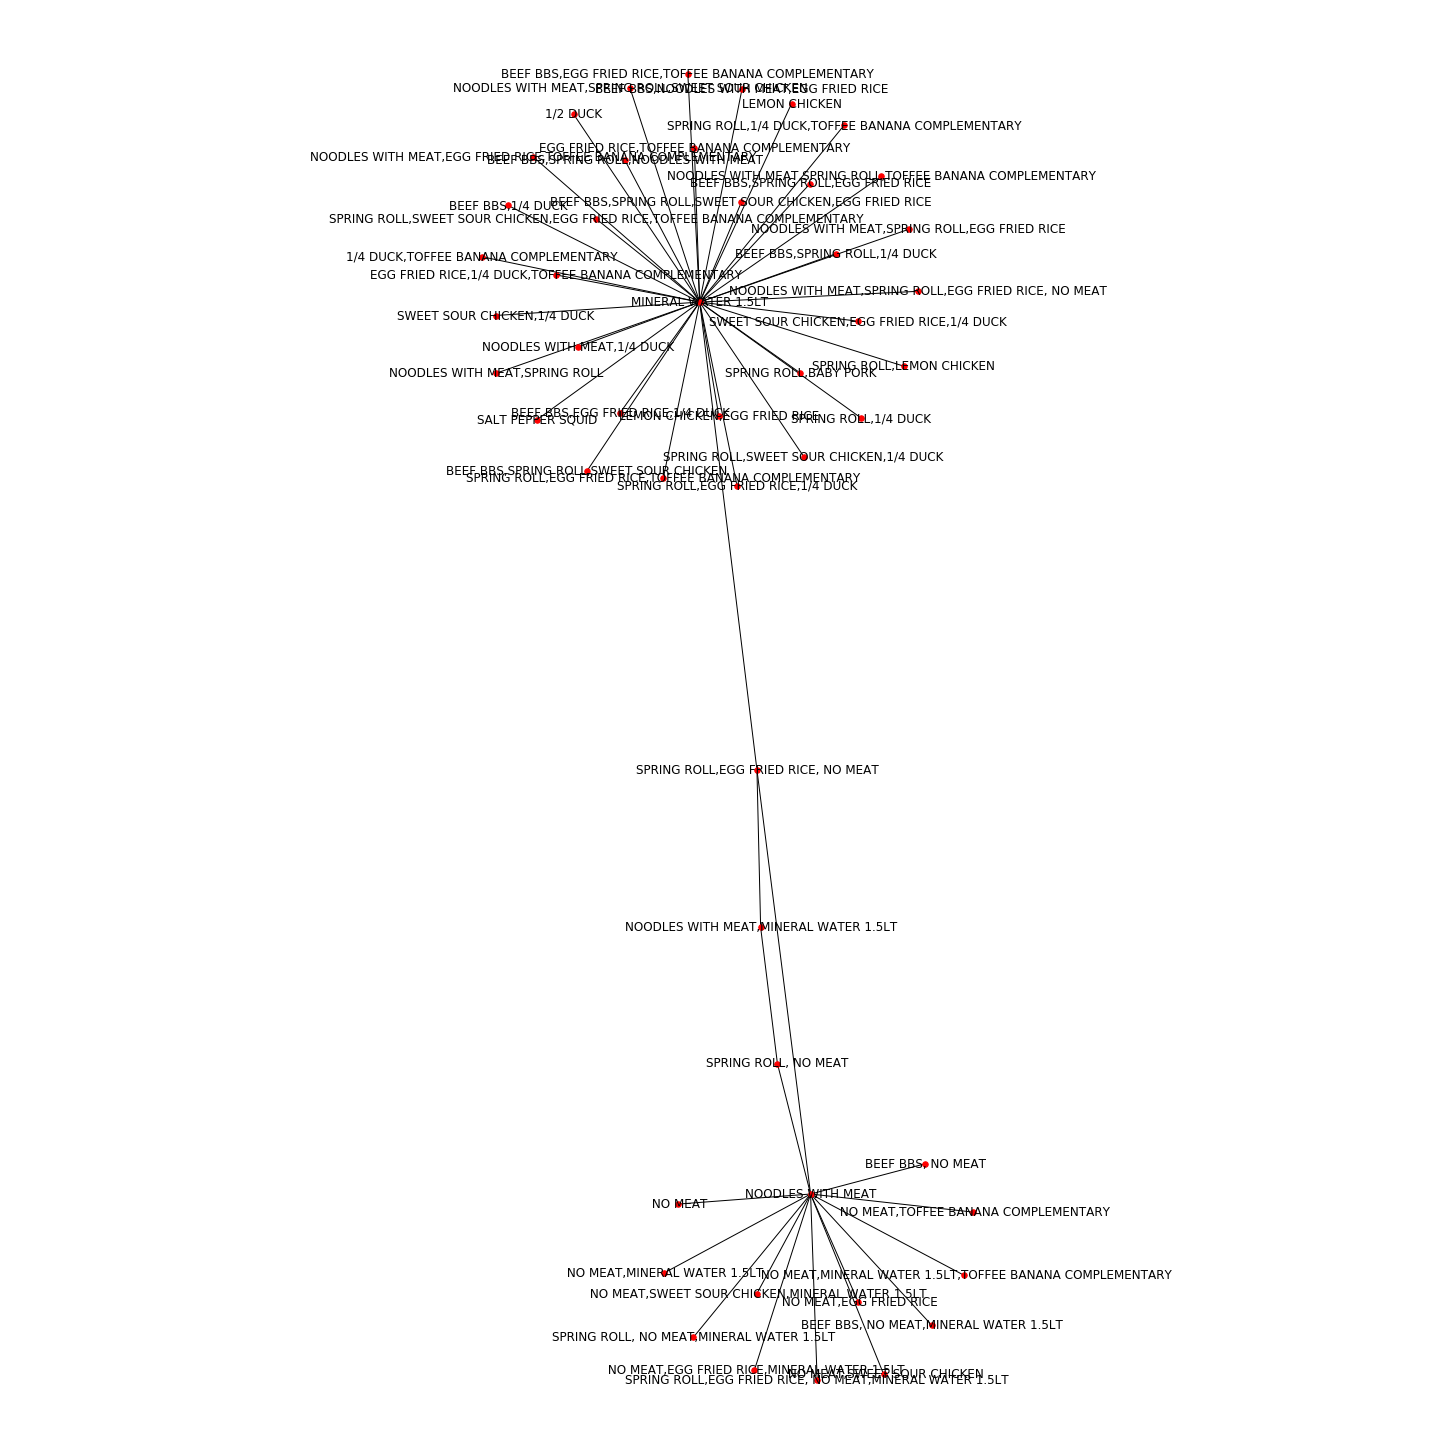

In [88]:
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234)
plt.axis('equal')
plt.show()
#fig.savefig('figure.svg')

##### 2) Delivery

In [89]:
priori_c = casa[['DocNumber','ProductDesignation']]


In [90]:
for col in ['DocNumber', 'ProductDesignation']:
    priori_c[col] = priori_c[col].astype('category')

/Users/madalenabotelho/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
priori_c.describe()

DocNumber ProductDesignation
count              30451              30451
unique              4866                146
top     TKD0320033962018    DELIVERY CHARGE
freq                  19               3887

- 30451 transactions in 4866 documents
- 146 different Products
- Max 19 lines per document
- Most sold item "DELIVERY CHARGE" (3887)

##### 13.2.1) PIVOT TABLE


In [92]:
# Pivot the data - lines as documents and products as columns
pc = pd.pivot_table(priori_c, index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pc.head()

ProductDesignation   EXTRA PANCAKES   EXTRA SALAD   EXTRA SAUCE  \
DocNumber                                                         
TKD0310000012018                0.0           0.0           0.0   
TKD0310000022018                0.0           0.0           0.0   
TKD0310000032018                0.0           0.0           0.0   
TKD0310000042018                0.0           0.0           0.0   
TKD0310000052018                0.0           0.0           0.0   

ProductDesignation   NO BEANSPROUTS   NO CHILLY   NO EGG   NO MEAT  \
DocNumber                                                            
TKD0310000012018                0.0         0.0      0.0       0.0   
TKD0310000022018                0.0         0.0      0.0       0.0   
TKD0310000032018                0.0         0.0      0.0       0.0   
TKD0310000042018                0.0         0.0      0.0       0.0   
TKD0310000052018                0.0         0.0      0.0       0.0   

ProductDesignation   NO MUSHROOMS   NO ONION   NO PORK  ...  TANDOORI TRILOGY  \
DocNumber                                               ...                     
TKD0310000012018              0.0        0.0       0.0  ...               1.0   
TKD0310000022018              0.0        0.0       0.0  ...               0.0   
TKD0310000032018              0.0        0.0       0.0  ...               0.0   
TKD0310000042018              0.0        0.0       0.0  ...               0.0   
TKD0310000052018              0.0        0.0       0.0  ...               1.0   

ProductDesignation  TEMPURA MAKI  TIN JIAN STYLE CHICKEN  TSANTA  VEG BBS  \
DocNumber                                                                   
TKD0310000012018             0.0                     0.0     0.0      0.0   
TKD0310000022018             0.0                     0.0     0.0      0.0   
TKD0310000032018             0.0                     0.0     0.0      0.0   
TKD0310000042018             0.0                     0.0     0.0      0.0   
TKD0310000052018             0.0                     0.0     0.0      0.0   

ProductDesignation  VEG RICE  VOLCANO MAKI  WHOLE DUCK  WINE  YELLOW DAL DHABA  
DocNumber                                                                       
TKD0310000012018         0.0           0.0         0.0   0.0               0.0  
TKD0310000022018         0.0           0.0         0.0   0.0               0.0  
TKD0310000032018         0.0           0.0         0.0   0.0               0.0  
TKD0310000042018         0.0           0.0         0.0   0.0               0.0  
TKD0310000052018         0.0           0.0         0.0   0.0               0.0  

[5 rows x 146 columns]

In [93]:
# Apply the APRIORI algorithm
# Rules supported in at least 10% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(pc, min_support=0.05, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)
frequent_itemsets.head()

support                           itemsets
10  0.798808                  (DELIVERY CHARGE)
11  0.412659                   (EGG FRIED RICE)
28  0.359433                           (TSANTA)
23  0.354706                      (SPRING ROLL)
53  0.336210  (EGG FRIED RICE, DELIVERY CHARGE)

In [94]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.70)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

antecedents          consequents  \
55                   ( NO MEAT, DELIVERY CHARGE)  (NOODLES WITH MEAT)   
39                                    ( NO MEAT)  (NOODLES WITH MEAT)   
1                                       (TSANTA)    (DELIVERY CHARGE)   
46               (EGG FRIED RICE, SESAME PRAWNS)    (DELIVERY CHARGE)   
26  (SWEET SOUR CHICKEN, EGG FRIED RICE, TSANTA)    (DELIVERY CHARGE)   

    antecedent support  consequent support   support  confidence      lift  \
55            0.051377            0.125976  0.051377    1.000000  7.938010   
39            0.062474            0.125976  0.062474    1.000000  7.938010   
1             0.359433            0.798808  0.311344    0.866209  1.084377   
46            0.065146            0.798808  0.056309    0.864353  1.082054   
26            0.085697            0.798808  0.073983    0.863309  1.080747   

    leverage  conviction  
55  0.044905         inf  
39  0.054604         inf  
1   0.024226    1.503781  
46  0.004270    1.483206  
26  0.005528    1.471878

Rule with (NO MEAT) > (NOODLES WITH MEAT):

- Support = 6%, which means that 6% of all transactions under analysis show that whoever selected NO MEAT also bought NOODLES WITH MEAT.

- Confidence = 1.0 means that 100% of transactions where customers have selected NO MEAT, present NOODLES WITH MEAT as a purchased product.

- Lift = 7.9, so NO MEAT is positively and highly correlated with NOODLES WITH MEAT, which means that the occurrence of one implies the occurrence of another (highly associated).

In [95]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head(10)

antecedents  \
29                        ( EXTRA SAUCE)   
28                     ( EXTRA PANCAKES)   
49                            ( NO MEAT)   
46  (NOODLES WITH MEAT, DELIVERY CHARGE)   
48                   (NOODLES WITH MEAT)   
47           ( NO MEAT, DELIVERY CHARGE)   
31                            ( NO MEAT)   
30                   (NOODLES WITH MEAT)   
43                          (JIRA PULAO)   
42                                (NAAN)   

                             consequents  antecedent support  \
29                     ( EXTRA PANCAKES)            0.090423   
28                        ( EXTRA SAUCE)            0.085491   
49  (NOODLES WITH MEAT, DELIVERY CHARGE)            0.062474   
46                            ( NO MEAT)            0.103576   
48           ( NO MEAT, DELIVERY CHARGE)            0.125976   
47                   (NOODLES WITH MEAT)            0.051377   
31                   (NOODLES WITH MEAT)            0.062474   
30                            ( NO MEAT)            0.125976   
43                                (NAAN)            0.097205   
42                          (JIRA PULAO)            0.119400   

    consequent support   support  confidence      lift  leverage  conviction  
29            0.085491  0.063913    0.706818  8.267734  0.056182    3.119255  
28            0.090423  0.063913    0.747596  8.267734  0.056182    3.603656  
49            0.103576  0.051377    0.822368  7.939771  0.044906    5.046536  
46            0.062474  0.051377    0.496032  7.939771  0.044906    1.860287  
48            0.051377  0.051377    0.407830  7.938010  0.044905    1.601945  
47            0.125976  0.051377    1.000000  7.938010  0.044905         inf  
31            0.125976  0.062474    1.000000  7.938010  0.054604         inf  
30            0.062474  0.062474    0.495922  7.938010  0.054604    1.859881  
43            0.119400  0.052815    0.543340  4.550593  0.041209    1.928351  
42            0.097205  0.052815    0.442341  4.550593  0.041209    1.618901

- The rules (JIRA PULAO)> (NAAN) and (NAAN)> (JIRA PULAO) have the same support, lift, but confidence is different, both variables are highly associated. The only difference is that the probability of buying NAAN knowing that you also bought JIRA PULAO is 54% while that of buying JIRA PULAO knowing that you bought NAAN is 44%.

##### 13.2.2) Explore frequent_itemsets


In [96]:
# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

support                                           itemsets  length
10   0.798808                                  (DELIVERY CHARGE)       1
11   0.412659                                   (EGG FRIED RICE)       1
28   0.359433                                           (TSANTA)       1
23   0.354706                                      (SPRING ROLL)       1
53   0.336210                  (EGG FRIED RICE, DELIVERY CHARGE)       2
..        ...                                                ...     ...
90   0.051377     (NOODLES WITH MEAT,  NO MEAT, DELIVERY CHARGE)       3
123  0.051171  (SPRING ROLL, SWEET SOUR CHICKEN, TSANTA, DELI...       4
20   0.051171                                (SALT PEPPER SQUID)       1
88   0.050966                 (SWEET SOUR CHICKEN, STEAMED RICE)       2
29   0.050966                                         (VEG RICE)       1

[124 rows x 3 columns]

Set high Confidence and high Lift to find the rules with stronger associations. 

In [97]:
rulesConfidence[(rulesConfidence['confidence'] >= 0.7) & (rulesConfidence['lift'] >= 3)]

antecedents                           consequents  \
55  ( NO MEAT, DELIVERY CHARGE)                   (NOODLES WITH MEAT)   
39                   ( NO MEAT)                   (NOODLES WITH MEAT)   
56                   ( NO MEAT)  (NOODLES WITH MEAT, DELIVERY CHARGE)   
33            ( EXTRA PANCAKES)                        ( EXTRA SAUCE)   
34               ( EXTRA SAUCE)                     ( EXTRA PANCAKES)   

    antecedent support  consequent support   support  confidence      lift  \
55            0.051377            0.125976  0.051377    1.000000  7.938010   
39            0.062474            0.125976  0.062474    1.000000  7.938010   
56            0.062474            0.103576  0.051377    0.822368  7.939771   
33            0.085491            0.090423  0.063913    0.747596  8.267734   
34            0.090423            0.085491  0.063913    0.706818  8.267734   

    leverage  conviction  
55  0.044905         inf  
39  0.054604         inf  
56  0.044906    5.046536  
33  0.056182    3.603656  
34  0.056182    3.119255

In [98]:
### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]


In [99]:
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)

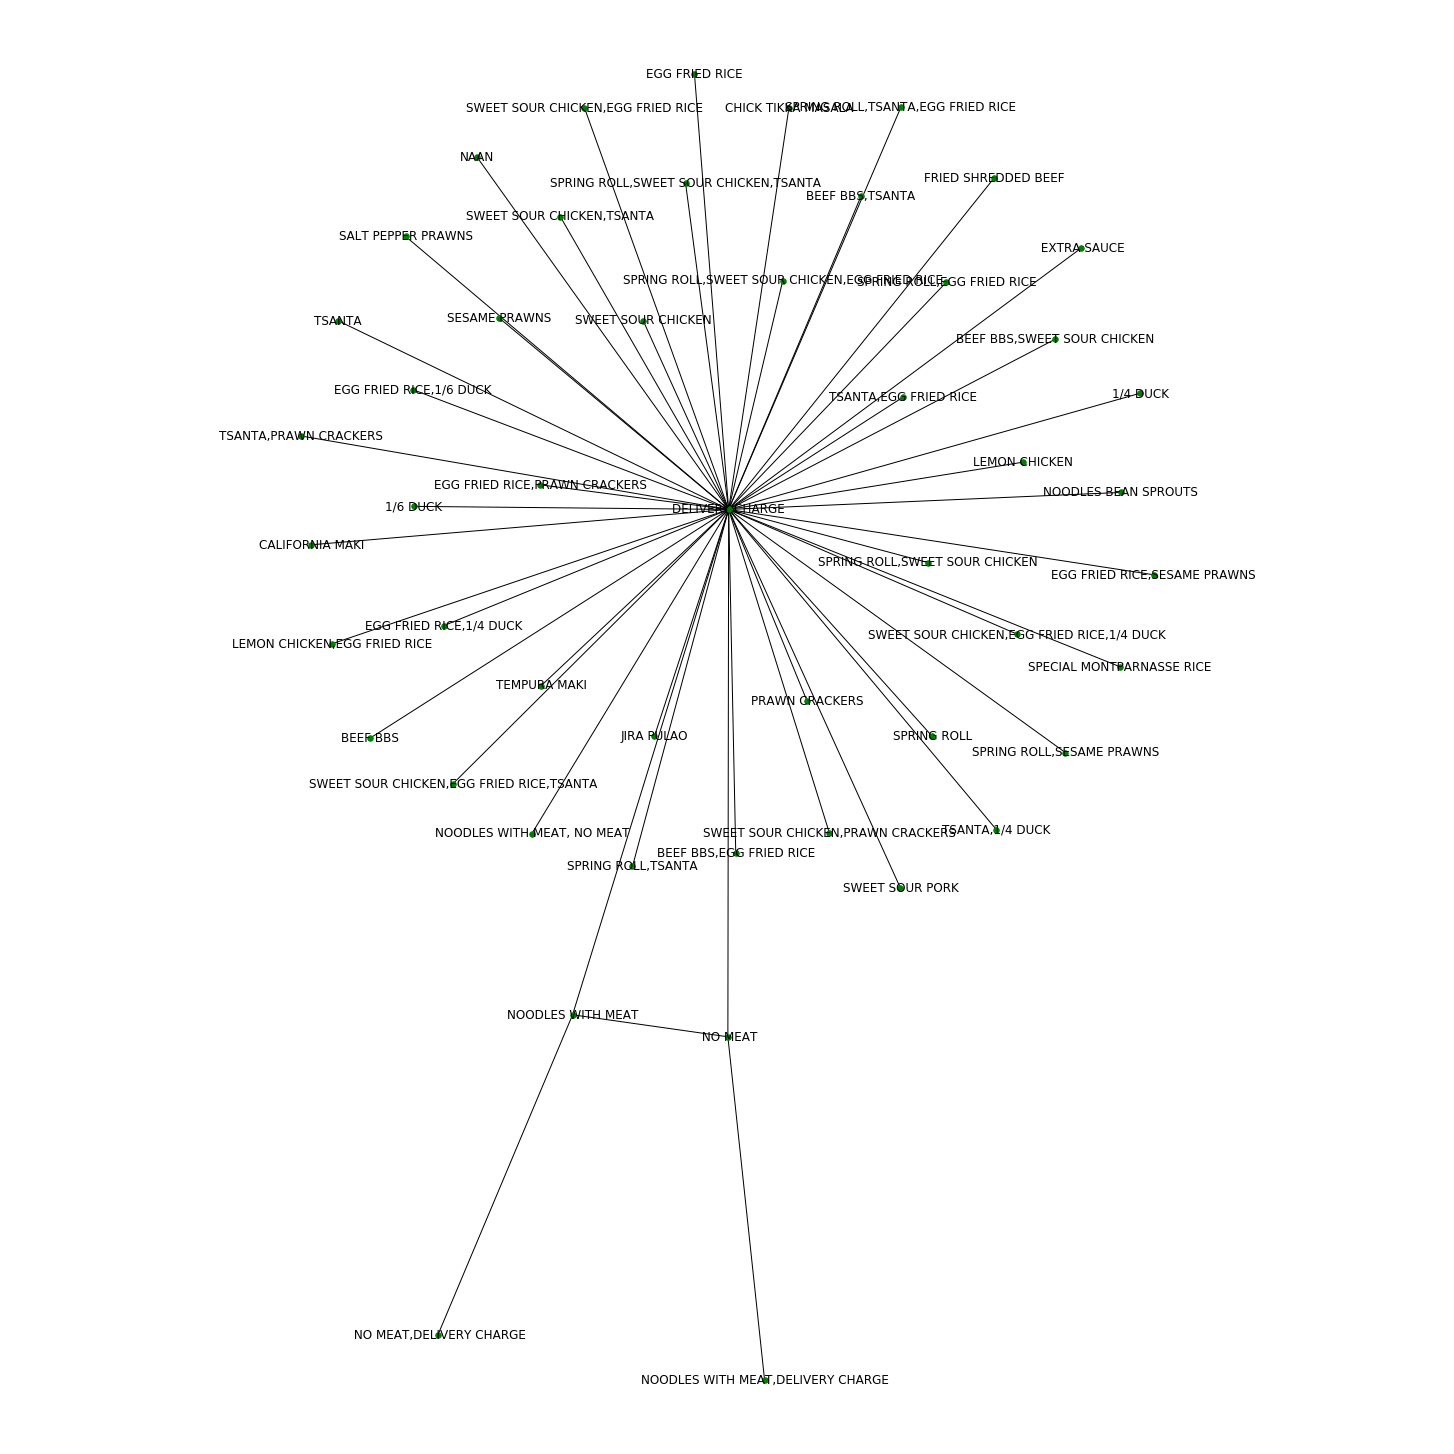

In [100]:
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')
nx.draw(G, with_labels=True, node_size=30, node_color="green", pos=nx.spring_layout(G), seed=1234)
plt.axis('equal')
plt.show()
#fig.savefig('figure.svg')

# `MARKETING STRATEGY`

With the analysis that we have made through the Apriori algorithm we discover some relations between the orders and the products, so one of our proposals to new products is to create a dish of Noodles but without meat, once that most of the orders were with that special request.
Given these results in the a priori, combined with the exploratory analysis, namely from the holidays, we created the following MENUS:

#### Menu 1: Vegetarian Noodles with Spring rolls, and Mineral Water;

#### Menu 2: Vegetarian Noodles with Egg Fried Rice;

#### Menu 3: Vegetarian Noodles with Beef BBS;

#### Menu 4: Vegetarian Noodles with Sweet Sour Chicken.


PROMOTIONS:
#### (1) Mother’s Day, with the offer of 2 beverages;

#### (2) Children’s Day, if people bring their child, the restaurant could offer a dessert;

#### (3) With a purchase of 1 pancake, we offer extra sauce;

#### (4) 10% discount in the delivery charge after the fifth order of Noodles.

#### (5) If a menu is purchased on a Sunday, Monday, Tuesday or Thursday, it is offered one pancake.


